<a id='top'></a>

# Data Engineering of 21st Club and TransferMarkt Datasets
##### Notebook to engineer the raw data from [21st Club](https://www.21stclub.com/) using [pandas](http://pandas.pydata.org/).

### By [Edd Webster](https://www.twitter.com/eddwebster)
Last updated: 19/09/2020

![title](../../img/21st_club.png)

![title](../../img/transfermarkt-logo-banner.png)

Click [here](#section5) to jump straight to the Exploratory Data Analysis section and skip the [Task Brief](#section2), [Data Sources](#section3), and [Data Engineering](#section4) sections. Or click [here](#section6) to jump straight to the Conclusion.

___

<a id='sectionintro'></a>

## <a id='import_libraries'>Introduction</a>
This notebook engineers the data of EFL players provided by 21st Club and joins this to scraped, player valuation data from [TransferMarkt](https://www.transfermarkt.co.uk/) for each of the 18/19 and 19/20 season.

This notebook uses [pandas](http://pandas.pydata.org/) for data manipulation through DataFrames and [RecordLinkage](https://pypi.org/project/recordlinkage/) for matching fuzzy datasets.

For more information about this notebook and the author, I'm available through all the following channels:
*    [eddwebster.com](https://www.eddwebster.com/),
*    edd.j.webster@gmail.com,
*    [@eddwebster](https://www.twitter.com/eddwebster),
*    [linkedin.com/in/eddwebster](https://www.linkedin.com/in/eddwebster/),
*    [github/eddwebster](https://github.com/eddwebster/), and 
*    [public.tableau.com/profile/edd.webster](https://public.tableau.com/profile/edd.webster).

The accompanying GitHub repository for this notebook can be found [here](https://github.com/eddwebster/fifa-league) and a static version of this notebook can be found [here](https://nbviewer.jupyter.org/github/eddwebster/fifa-league/blob/master/FIFA%2020%20Fantasy%20Football%20League%20using%20TransferMarkt%20Player%20Valuations.ipynb).

___

<a id='sectioncontents'></a>

## <a id='notebook_contents'>Notebook Contents</a>
1.    [Notebook Dependencies](#section1)<br>
2.    [Project Brief](#section2)<br>
3.    [Data Sources](#section3)<br>
      1.    [Introduction](#section3.1)<br>
      2.    [Data Dictionary](#section3.2)<br>
      3.    [Creating the DataFrame](#section3.3)<br>
      4.    [Initial Data Handling](#section3.4)<br>
      5.    [Export the Raw DataFrame](#section3.5)<br>         
4.    [Data Engineering](#section4)<br>
      1.    [Introduction](#section4.1)<br>
      2.    [Columns of Interest](#section4.2)<br>
      3.    [String Cleaning](#section4.3)<br>
      4.    [Converting Data Types](#section4.4)<br>
      5.    [Export the Engineered DataFrame](#section4.5)<br>
5.    [Exploratory Data Analysis (EDA)](#section5)<br>
      1.    [...](#section5.1)<br>
      2.    [...](#section5.2)<br>
      3.    [...](#section5.3)<br>
6.    [Summary](#section6)<br>
7.    [Next Steps](#section7)<br>
8.    [Bibliography](#section8)<br>

___

<a id='section1'></a>

## <a id='#section1'>1. Notebook Dependencies</a>

This notebook was written using [Python 3](https://docs.python.org/3.7/) and requires the following libraries:
*    [`Jupyter notebooks`](https://jupyter.org/) for this notebook environment with which this project is presented;
*    [`NumPy`](http://www.numpy.org/) for multidimensional array computing;
*    [`pandas`](http://pandas.pydata.org/) for data analysis and manipulation;
*    [`matplotlib`](https://matplotlib.org/contents.html?v=20200411155018) for data visualisations;

All packages used for this notebook except for BeautifulSoup can be obtained by downloading and installing the [Conda](https://anaconda.org/anaconda/conda) distribution, available on all platforms (Windows, Linux and Mac OSX). Step-by-step guides on how to install Anaconda can be found for Windows [here](https://medium.com/@GalarnykMichael/install-python-on-windows-anaconda-c63c7c3d1444) and Mac [here](https://medium.com/@GalarnykMichael/install-python-on-mac-anaconda-ccd9f2014072), as well as in the Anaconda documentation itself [here](https://docs.anaconda.com/anaconda/install/).

### Import Libraries and Modules

In [92]:
# Python ≥3.5 (ideally)
import platform
import sys, getopt
assert sys.version_info >= (3, 5)
import csv

# Import Dependencies
%matplotlib inline

# Math Operations
import numpy as np
from math import pi

# Datetime
import datetime
from datetime import date
import time

# Data Preprocessing
import pandas as pd    # version 1.0.3
import os    #  used to read the csv filenames
import re
import random
from io import BytesIO
from pathlib import Path

# Reading directories
import glob
import os
from os.path import basename

# Working with JSON
import json
from pandas.io.json import json_normalize

# Web Scraping
import requests
from bs4 import BeautifulSoup
import re

# Football Libraries - radar plots
import soccerplots
from soccerplots.radar_chart import Radar

# Fuzzy Matching - Record Linkage
import recordlinkage
import jellyfish
import numexpr as ne

# Data Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')
import missingno as msno    # visually display missing data

# Progress Bar
from tqdm import tqdm    # a clean progress bar library

# Display in Jupyter
from IPython.display import Image, YouTubeVideo
from IPython.core.display import HTML

# Ignore Warnings
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

print('Setup Complete')

Setup Complete


In [93]:
# Python / module versions used here for reference
print('Python: {}'.format(platform.python_version()))
print('NumPy: {}'.format(np.__version__))
print('pandas: {}'.format(pd.__version__))
print('matplotlib: {}'.format(mpl.__version__))
print('Seaborn: {}'.format(sns.__version__))

Python: 3.7.6
NumPy: 1.18.1
pandas: 1.0.1
matplotlib: 3.1.3
Seaborn: 0.10.0


### Defined Variables

In [94]:
# Define today's date
today = datetime.datetime.now().strftime('%d/%m/%Y').replace('/', '')

### Defined Filepaths

In [95]:
# Set up initial paths to subfolders
base_dir = os.path.join('..', '..')
data_dir = os.path.join(base_dir, 'data')
data_dir_21st_club = os.path.join(base_dir, 'data', '21st_club')
data_dir_tm = os.path.join(base_dir, 'data', 'tm')
data_dir_21st_club_tm = os.path.join(base_dir, 'data', '21st_club-tm')
img_dir = os.path.join(base_dir, 'img')
fig_dir = os.path.join(base_dir, 'img', 'fig')
video_dir = os.path.join(base_dir, 'video')

---

<a id='section2'></a>

## <a id='#section2'>2. Project Brief</a>
This Jupyter notebook engineers the data of EFL players provided by [21st Club](https://www.21stclub.com/) and joins this to scraped, player valuation data from [TransferMarkt](https://www.transfermarkt.co.uk/).

This notebook uses [pandas](http://pandas.pydata.org/) for data manipulation through DataFrames and [RecordLinkage](https://pypi.org/project/recordlinkage/) for matching fuzzy datasets.

The data of player values produced in this notebook is exported to CSV. This data can be further analysed in Python, joined to other datasets, or explored using Tableau, PowerBI, Microsoft Excel.

For this project, the data has been visualised in Tableau which can be found in the dashboard titled: Derby County Data Analysis at my Tableau Public profile [here](https://public.tableau.com/profile/edd.webster).

---

<a id='section3'></a>

## <a id='#section3'>3. Data Source</a>

### <a id='#section3.1'>3.1. Introduction</a>
The data was provided by [21st Club](https://www.21stclub.com/).

Before conducting our EDA, the data needs to be imported as a DataFrame in the Data Sources section [Section 3](#section3) and Cleaned in the Data Engineering section [Section 4](#section4).

We'll be using the [pandas](http://pandas.pydata.org/) library to import our data to this workbook as a DataFrame.

### <a id='#section3.2'>3.2. 21st Club</a>

#### <a id='#section3.2.1.'>3.2.1. Data Dictionaries</a>
The [21st Club](https://www.21stclub.com/) dataset has six features (columns) with the following definitions and data types:

| Feature     | Data type    |
|------|-----|
| `season`    | object    |
| `competition_id`    | int64    |
| `competition`    | object    |
| `player_id`    | int64    |
| `name`    | object    |
| `team_id`    | int64    |
| `team`    | object    |
| `age`    | float64    |
| `nationality`    | object    |
| `height`    | int64    |
| `weight`    | int64    |
| `preferred_foot`    | object    |
| `position`    | object    |
| `detailed_position`    | object    |
| `goals`    | int64    |
| `assists`    | int64    |
| `position_am_perc`    | float64    |
| `position_cb_perc`    | float64    |
| `position_cf_perc`    | float64    |
| `position_cm_perc`    | float64    |
| `position_dm_perc`    | float64    |
| `position_gk_perc`    | float64    |
| `position_lb_perc`    | float64    |
| `position_lw_perc`    | float64    |
| `position_rb_perc`    | float64    |
| `position_rw_perc`    | float64    |
| `play_time`    | int64    |
| `ball_in_play_time`    | int64    |
| `shots`    | int64    |
| `shots_open_play`    | int64    |
| `shots_open_play_box`    | int64    |
| `shots_op_left_foot`    | int64    |
| `shots_op_right_foot`    | int64    |
| `shots_op_head`    | int64    |
| `crosses`    | int64    |
| `crosses_open_play`    | int64    |
| `crosses_op_successful`    | int64    |
| `crosses_op_left`    | int64    |
| `crosses_op_right`    | int64    |
| `passes`    | int64    |
| `passes_open_play`    | int64    |
| `passes_op_successful`    | int64    |
| `passes_op_head`    | int64    |
| `passes_op_head_successful`    | int64    |
| `passes_op_final_third`    | int64    |
| `passes_op_final_third_successful`    | int64    |
| `passes_op_box`    | int64    |
| `passes_op_box_successful`    | int64    |
| `launches`    | int64    |
| `launches_successful`    | int64    |
| `carries`    | int64    |
| `carries_box`    | int64    |
| `carry_distance`    | float64    |
| `dribbles`    | int64    |
| `dribbles_successful`    | int64    |
| `dribbles_box`    | int64    |
| `recoveries`    | int64    |
| `tackles`    | int64    |
| `interceptions`    | int64    |
| `blocks`    | int64    |
| `clearances`    | int64     |
| `saves`    | int64     |
| `aerial_duels_att`    | int64    |
| `aerial_duels_att_won`    | int64    |
| `ground_duels_att`    | int64    |
| `ground_duels_att_won`    | int64     |
| `aerial_duels_def`    | int64    |
| `aerial_duels_def_won`    | int64    |
| `ground_duels_def`    | int64     |
| `ground_duels_def_won`    | int64     |

#### <a id='#section3.2.2'>3.2.2. Creating the DataFrame - scraping the data</a>
Import CSV file as a [pandas](http://pandas.pydata.org/) DataFrame.

In [96]:
# Import CSV file as a pandas DataFrame, df_21stclub_raw

## Define filepath
filepath_data = os.path.join(data_dir_21st_club, 'raw/21st_club_data.csv')

## Create DataFrame
df_21stclub_raw = pd.read_csv(filepath_data)

#### <a id='#section3.2.3'>3.2.3. Preliminary Data Handling</a>
Let's quality of the dataset by looking first and last rows in pandas using the [head()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.head.html) and [tail()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.tail.html) methods.

In [97]:
# Display the first 5 rows of the raw DataFrame, df_21stclub_raw
df_21stclub_raw.head()

,season,competition_id,competition,player_id,name,team_id,team,age,nationality,height,...,clearances,saves,aerial_duels_att,aerial_duels_att_won,ground_duels_att,ground_duels_att_won,aerial_duels_def,aerial_duels_def_won,ground_duels_def,ground_duels_def_won
0,2018/2019,70,Championship,173879,Tamaraebi Abraham,7,Aston Villa,22.0,England,190.0,...,45,0,266,109,125,59,35,22,40,24
1,2018/2019,70,Championship,172649,Dean Henderson,49,Sheffield United,23.0,England,188.0,...,21,115,5,4,7,7,18,1,0,0
2,2018/2019,70,Championship,108416,John Egan,49,Sheffield United,27.0,Republic of Ireland,185.0,...,258,0,69,37,21,17,240,82,57,32
3,2018/2019,70,Championship,184341,Mason Mount,24,Derby County,21.0,England,178.0,...,29,0,52,13,106,43,15,10,74,39
4,2018/2019,70,Championship,146610,Jack O'Connell,49,Sheffield United,26.0,England,190.0,...,198,0,49,25,29,25,245,73,30,19


In [98]:
# Display the last 5 rows of the raw DataFrame, df_21stclub_raw
df_21stclub_raw.tail()

,season,competition_id,competition,player_id,name,team_id,team,age,nationality,height,...,clearances,saves,aerial_duels_att,aerial_duels_att_won,ground_duels_att,ground_duels_att_won,aerial_duels_def,aerial_duels_def_won,ground_duels_def,ground_duels_def_won
2626,2019/2020,32,League Two,223827,Daniel Ballard,46,Swindon Town,20.0,Northern Ireland,187.0,...,0,0,0,0,0,0,0,0,0,0
2627,2019/2020,32,League Two,217199,Jack Kiersey,42,Walsall,21.0,England,NaN,...,0,0,1,1,0,0,4,1,1,0
2628,2018/2019,70,Championship,221824,Lewis Walker,52,Queens Park Rangers,22.0,England,NaN,...,0,0,3,2,3,0,1,1,1,1
2629,2018/2019,70,Championship,209412,Ryan East,108,Reading,22.0,England,NaN,...,0,0,0,0,1,1,0,0,0,0
2630,2018/2019,70,Championship,435858,Fraser Preston,19,Sheffield Wednesday,21.0,Scotland,NaN,...,0,0,2,0,0,0,0,0,0,0


In [99]:
# Print the shape of the raw DataFrame, df_21stclub_raw
print(df_21stclub_raw.shape)

(2631, 70)


In [100]:
# Print the column names of the raw DataFrame, df_21stclub_raw
print(df_21stclub_raw.columns)

Index(['season', 'competition_id', 'competition', 'player_id', 'name',
       'team_id', 'team', 'age', 'nationality', 'height', 'weight',
       'preferred_foot', 'position', 'detailed_position', 'goals', 'assists',
       'position_am_perc', 'position_cb_perc', 'position_cf_perc',
       'position_cm_perc', 'position_dm_perc', 'position_gk_perc',
       'position_lb_perc', 'position_lw_perc', 'position_rb_perc',
       'position_rw_perc', 'play_time', 'ball_in_play_time', 'shots',
       'shots_open_play', 'shots_open_play_box', 'shots_op_left_foot',
       'shots_op_right_foot', 'shots_op_head', 'crosses', 'crosses_open_play',
       'crosses_op_successful', 'crosses_op_left', 'crosses_op_right',
       'passes', 'passes_open_play', 'passes_op_successful', 'passes_op_head',
       'passes_op_head_successful', 'passes_op_final_third',
       'passes_op_final_third_successful', 'passes_op_box',
       'passes_op_box_successful', 'launches', 'launches_successful',
       'carries', 'ca

The dataset has six features (columns). Full details of these attributes can be found in the [Data Dictionary](section3.3.1).

In [101]:
# Data types of the features of the raw DataFrame, df_21stclub_raw
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df_21stclub_raw.dtypes)

season                               object
competition_id                        int64
competition                          object
player_id                             int64
name                                 object
team_id                               int64
team                                 object
age                                 float64
nationality                          object
height                              float64
weight                              float64
preferred_foot                       object
position                             object
detailed_position                    object
goals                                 int64
assists                               int64
position_am_perc                    float64
position_cb_perc                    float64
position_cf_perc                    float64
position_cm_perc                    float64
position_dm_perc                    float64
position_gk_perc                    float64
position_lb_perc                

All six of the columns have the object data type. Full details of these attributes and their data types can be found in the [Data Dictionary](section3.3.1).

In [102]:
# Info for the raw DataFrame, df_21stclub_raw
df_21stclub_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2631 entries, 0 to 2630
Data columns (total 70 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   season                            2631 non-null   object 
 1   competition_id                    2631 non-null   int64  
 2   competition                       2631 non-null   object 
 3   player_id                         2631 non-null   int64  
 4   name                              2631 non-null   object 
 5   team_id                           2631 non-null   int64  
 6   team                              2631 non-null   object 
 7   age                               2617 non-null   float64
 8   nationality                       2631 non-null   object 
 9   height                            2336 non-null   float64
 10  weight                            2239 non-null   float64
 11  preferred_foot                    1851 non-null   object 
 12  positi

In [103]:
# Description of the raw DataFrame, df_21stclub_raw, showing some summary statistics for each numberical column in the DataFrame
df_21stclub_raw.describe()

,competition_id,player_id,team_id,age,height,weight,goals,assists,position_am_perc,position_cb_perc,...,clearances,saves,aerial_duels_att,aerial_duels_att_won,ground_duels_att,ground_duels_att_won,aerial_duels_def,aerial_duels_def_won,ground_duels_def,ground_duels_def_won
count,2631.000000,2631.000000,2631.000000,2617.000000,2336.000000,2239.000000,2631.000000,2631.000000,2596.000000,2596.000000,...,2631.000000,2631.000000,2631.000000,2631.000000,2631.000000,2631.000000,2631.000000,2631.000000,2631.000000,2631.000000
mean,47.625238,144087.258837,197.521475,26.388613,181.923373,75.041983,1.969593,1.336374,4.687982,17.388290,...,28.171038,3.665146,32.652604,13.293425,27.160015,14.163056,33.787153,13.710756,27.253136,14.059293
std,23.623605,106297.991456,529.506675,4.516356,6.560712,6.956653,3.333410,2.016973,12.252942,34.875405,...,41.947256,16.899254,62.690642,29.230508,30.657544,16.215974,49.783092,18.142118,27.306564,14.381583
min,15.000000,1409.000000,2.000000,16.000000,156.000000,55.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32.000000,62623.500000,40.000000,23.000000,178.000000,70.000000,0.000000,0.000000,0.000000,0.000000,...,3.000000,0.000000,3.000000,1.000000,5.000000,2.000000,4.000000,1.000000,5.000000,2.000000
50%,70.000000,123352.000000,77.000000,26.000000,182.000000,75.000000,1.000000,1.000000,0.000000,0.000000,...,12.000000,0.000000,13.000000,5.000000,17.000000,9.000000,13.000000,7.000000,19.000000,10.000000
75%,70.000000,196409.000000,106.000000,29.000000,186.000000,80.000000,3.000000,2.000000,3.000000,4.000000,...,34.000000,0.000000,35.000000,13.000000,38.000000,20.000000,42.000000,19.000000,42.000000,22.000000
max,70.000000,497726.000000,3448.000000,41.000000,205.000000,102.000000,29.000000,16.000000,98.000000,100.000000,...,279.000000,163.000000,927.000000,518.000000,231.000000,159.000000,305.000000,112.000000,186.000000,97.000000


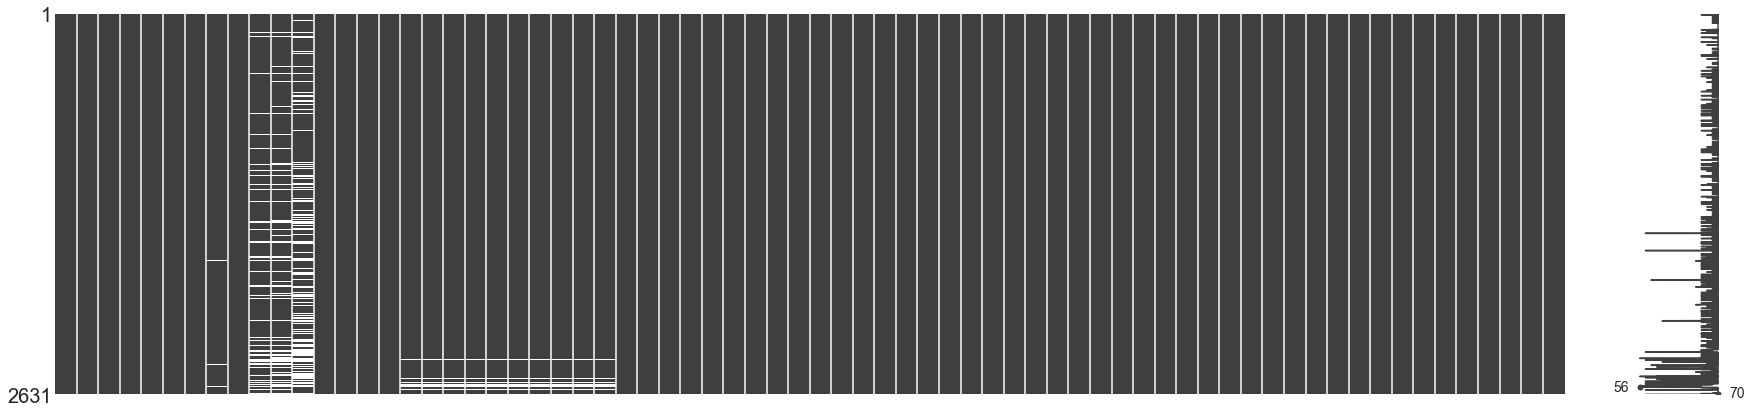

In [104]:
# Plot visualisation of the missing values for each feature of the raw DataFrame, df_21stclub_raw
msno.matrix(df_21stclub_raw, figsize = (30, 7))

In [105]:
# Counts of missing values
tm_null_value_stats = df_21stclub_raw.isnull().sum(axis=0)
tm_null_value_stats[tm_null_value_stats != 0]

age                  14
height              295
weight              392
preferred_foot      780
position_am_perc     35
position_cb_perc     35
position_cf_perc     35
position_cm_perc     35
position_dm_perc     35
position_gk_perc     35
position_lb_perc     35
position_lw_perc     35
position_rb_perc     35
position_rw_perc     35
dtype: int64

The visualisation shows us very quickly that there a few missing values in the `value` column, but otherwise the dataset is complete.

### <a id='#section3.3'>3.3. TransferMarkt</a>

#### <a id='#section3.3.1.'>3.3.1. Data Dictionaries</a>
The [TransferMarkt](https://www.transfermarkt.co.uk/) dataset has six features (columns) with the following definitions and data types:

| Feature     | Data type    |
|------|-----|
| `position_number`    | object     |
| `position_description`    | object     |
| `name`    | object     |
| `dob`    | object     |
| `nationality`    | object     |
| `value`    | object     |

#### <a id='#section3.3.2.'>3.3.2. Import Data</a>
Import CSV file as a [pandas](http://pandas.pydata.org/) DataFrame.

##### 2018/19 Season

In [106]:
# Import data as a pandas DataFrame, df_tm_players_england_1819

## Look for most recent CSV file
list_of_files = glob.glob(data_dir_tm + '/engineered/1819/*')    # * means all if need specific format then *.csv
filepath_latest_tm = max(list_of_files, key=os.path.getctime)

## Load in most recently parsed CSV file
df_tm_player_england_1819 = pd.read_csv(filepath_latest_tm)

##### 2019/20 Season

In [107]:
# Import data as a pandas DataFrame, df_tm_players_england_1920

## Look for most recent CSV file
list_of_files = glob.glob(data_dir_tm + '/engineered/1920/*')    # * means all if need specific format then *.csv
filepath_latest_tm = max(list_of_files, key=os.path.getctime)

## Load in most recently parsed CSV file
df_tm_player_england_1920 = pd.read_csv(filepath_latest_tm)

#### <a id='#section3.3.3'>3.3.3. Preliminary Data Handling</a>
Let's quality of the dataset by looking first and last rows in pandas using the [head()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.head.html) and [tail()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.tail.html) methods.

##### 2018/19 Season

In [108]:
# Display the first 5 rows of the raw DataFrame, df_tm_player_england_1819
df_tm_player_england_1819.head()

,name_lower,firstname_lower,lastname_lower,firstinitial_lower,day_of_birth,month_of_birth,year_of_birth,pob,cob,dob,...,current_club_country,market_value_euros,joined,contract_expires,contract_option,on_loan_from,on_loan_from_country,loan_contract_expiry,player_agent,market_value_pounds
0,helder costa,helder,costa,h,12.0,1.0,1994.0,Luanda,Angola,1994-12-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ian poveda,ian,poveda,i,9.0,2.0,2000.0,London,England,2000-09-02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,will huffer,will,huffer,w,30.0,10.0,1998.0,London,England,1998-10-30,...,NaN,100000.0,01/07/2020,NaN,NaN,NaN,NaN,NaN,Stellar Football Ltd,92000.0
3,ben white,ben,white,b,8.0,10.0,1997.0,Poole,England,1997-08-10,...,england,5500000.0,01/07/2018,30/06/2024,NaN,NaN,NaN,NaN,NaN,5060000.0
4,leif davis,leif,davis,l,12.0,1.0,2000.0,Newcastle,England,2000-12-01,...,england,100000.0,04/07/2018,30/06/2023,NaN,NaN,NaN,NaN,NaN,92000.0


In [109]:
# Display the last 5 rows of the raw DataFrame, df_tm_player_england_1819
df_tm_player_england_1819.tail()

,name_lower,firstname_lower,lastname_lower,firstinitial_lower,day_of_birth,month_of_birth,year_of_birth,pob,cob,dob,...,current_club_country,market_value_euros,joined,contract_expires,contract_option,on_loan_from,on_loan_from_country,loan_contract_expiry,player_agent,market_value_pounds
3029,conor thomas,conor,thomas,c,29.0,10.0,1993.0,Coventry,England,1993-10-29,...,england,150000.0,01/07/2018,30/06/2021,NaN,NaN,NaN,NaN,TRP Sports,138000.0
3030,chris clements,chris,clements,c,6.0,2.0,1990.0,Birmingham,England,1990-06-02,...,england,150000.0,27/08/2018,30/06/2021,NaN,NaN,NaN,NaN,NaN,138000.0
3031,alex addai,alex,addai,a,20.0,12.0,1993.0,London,England,1993-12-20,...,england,0.0,01/07/2018,30/06/2021,NaN,NaN,NaN,NaN,NaN,0.0
3032,tom chamberlain,tom,chamberlain,t,1.0,6.0,2002.0,Cheltenham,England,2002-01-06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3033,ben tozer,ben,tozer,b,1.0,3.0,1990.0,Plymouth,England,1990-01-03,...,england,200000.0,01/07/2018,30/06/2021,NaN,NaN,NaN,NaN,366 Group,184000.0


##### 2019/20 Season

In [110]:
# Display the first 5 rows of the raw DataFrame, df_tm_player_england_1920
df_tm_player_england_1920.head()

,name_lower,firstname_lower,lastname_lower,firstinitial_lower,day_of_birth,month_of_birth,year_of_birth,pob,cob,dob,...,current_club_country,market_value_euros,joined,contract_expires,contract_option,on_loan_from,on_loan_from_country,loan_contract_expiry,player_agent,market_value_pounds
0,helder costa,helder,costa,h,12.0,1.0,1994.0,Luanda,Angola,1994-01-12,...,england,8000000.0,2020-07-01,2024-06-30,NaN,NaN,NaN,NaN,Gestifute,7360000.0
1,ian poveda,ian,poveda,i,9.0,2.0,2000.0,London,England,2000-02-09,...,england,675000.0,2020-01-24,2024-06-30,NaN,NaN,NaN,NaN,Elite Project Group Ltd,621000.0
2,will huffer,will,huffer,w,30.0,10.0,1998.0,London,England,1998-10-30,...,NaN,100000.0,2020-07-01,NaN,NaN,NaN,NaN,NaN,Stellar Football Ltd,92000.0
3,ben white,ben,white,b,8.0,10.0,1997.0,Poole,England,1997-10-08,...,england,5500000.0,2018-07-01,2024-06-30,NaN,NaN,NaN,NaN,NaN,5060000.0
4,leif davis,leif,davis,l,12.0,1.0,2000.0,Newcastle,England,2000-01-12,...,england,100000.0,2018-07-04,2023-06-30,NaN,NaN,NaN,NaN,NaN,92000.0


In [111]:
# Display the first 5 rows of the raw DataFrame, df_tm_player_england_1920
df_tm_player_england_1920.tail()

,name_lower,firstname_lower,lastname_lower,firstinitial_lower,day_of_birth,month_of_birth,year_of_birth,pob,cob,dob,...,current_club_country,market_value_euros,joined,contract_expires,contract_option,on_loan_from,on_loan_from_country,loan_contract_expiry,player_agent,market_value_pounds
3228,conor thomas,conor,thomas,c,29.0,10.0,1993.0,Coventry,England,1993-10-29,...,england,150000.0,2018-07-01,2021-06-30,NaN,NaN,NaN,NaN,TRP Sports,138000.0
3229,chris clements,chris,clements,c,6.0,2.0,1990.0,Birmingham,England,1990-02-06,...,england,150000.0,2018-08-27,2021-06-30,NaN,NaN,NaN,NaN,NaN,138000.0
3230,alex addai,alex,addai,a,20.0,12.0,1993.0,London,England,1993-12-20,...,england,0.0,2018-07-01,2021-06-30,NaN,NaN,NaN,NaN,NaN,0.0
3231,tom chamberlain,tom,chamberlain,t,1.0,6.0,2002.0,Cheltenham,England,2002-06-01,...,england,0.0,2020-07-01,2021-06-30,NaN,NaN,NaN,NaN,NaN,0.0
3232,ben tozer,ben,tozer,b,1.0,3.0,1990.0,Plymouth,England,1990-03-01,...,england,200000.0,2018-07-01,2021-06-30,NaN,NaN,NaN,NaN,366 Group,184000.0


In [112]:
# Print the shape of the raw DataFrame, df_tm_player_england_1819
print(df_tm_player_england_1819.shape)

(3034, 25)


In [113]:
# Print the shape of the raw DataFrame, df_tm_player_england_1920
print(df_tm_player_england_1920.shape)

(3233, 25)


In [114]:
# Print the column names of the raw DataFrame, df_tm_player_england_1819
print(df_tm_player_england_1819.columns)

Index(['name_lower', 'firstname_lower', 'lastname_lower', 'firstinitial_lower',
       'day_of_birth', 'month_of_birth', 'year_of_birth', 'pob', 'cob', 'dob',
       'height', 'foot', 'second_citizenship', 'season', 'current_club',
       'current_club_country', 'market_value_euros', 'joined',
       'contract_expires', 'contract_option', 'on_loan_from',
       'on_loan_from_country', 'loan_contract_expiry', 'player_agent',
       'market_value_pounds'],
      dtype='object')


In [115]:
# Print the column names of the raw DataFrame, df_tm_player_england_1920
print(df_tm_player_england_1920.columns)

Index(['name_lower', 'firstname_lower', 'lastname_lower', 'firstinitial_lower',
       'day_of_birth', 'month_of_birth', 'year_of_birth', 'pob', 'cob', 'dob',
       'height', 'foot', 'second_citizenship', 'season', 'current_club',
       'current_club_country', 'market_value_euros', 'joined',
       'contract_expires', 'contract_option', 'on_loan_from',
       'on_loan_from_country', 'loan_contract_expiry', 'player_agent',
       'market_value_pounds'],
      dtype='object')


The dataset has six features (columns). Full details of these attributes can be found in the [Data Dictionary](section3.3.1).

In [116]:
# Data types of the features of the raw DataFrame, df_tm_player_england_1819
df_tm_player_england_1819.dtypes

name_lower               object
firstname_lower          object
lastname_lower           object
firstinitial_lower       object
day_of_birth            float64
month_of_birth          float64
year_of_birth           float64
pob                      object
cob                      object
dob                      object
height                  float64
foot                     object
second_citizenship       object
season                   object
current_club             object
current_club_country     object
market_value_euros      float64
joined                   object
contract_expires         object
contract_option          object
on_loan_from             object
on_loan_from_country     object
loan_contract_expiry     object
player_agent             object
market_value_pounds     float64
dtype: object

In [117]:
# Data types of the features of the raw DataFrame, df_tm_player_england_1920
df_tm_player_england_1920.dtypes

name_lower               object
firstname_lower          object
lastname_lower           object
firstinitial_lower       object
day_of_birth            float64
month_of_birth          float64
year_of_birth           float64
pob                      object
cob                      object
dob                      object
height                  float64
foot                     object
second_citizenship       object
season                   object
current_club             object
current_club_country     object
market_value_euros      float64
joined                   object
contract_expires         object
contract_option          object
on_loan_from             object
on_loan_from_country     object
loan_contract_expiry     object
player_agent             object
market_value_pounds     float64
dtype: object

All six of the columns have the object data type. Full details of these attributes and their data types can be found in the [Data Dictionary](section3.3.1).

In [118]:
# Info for the raw DataFrame, df_tm_player_england_1819
df_tm_player_england_1819.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3034 entries, 0 to 3033
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   name_lower            3034 non-null   object 
 1   firstname_lower       3034 non-null   object 
 2   lastname_lower        3034 non-null   object 
 3   firstinitial_lower    3034 non-null   object 
 4   day_of_birth          2979 non-null   float64
 5   month_of_birth        2979 non-null   float64
 6   year_of_birth         2979 non-null   float64
 7   pob                   2619 non-null   object 
 8   cob                   3033 non-null   object 
 9   dob                   2979 non-null   object 
 10  height                2655 non-null   float64
 11  foot                  2389 non-null   object 
 12  second_citizenship    904 non-null    object 
 13  season                3034 non-null   object 
 14  current_club          2212 non-null   object 
 15  current_club_country 

In [119]:
# Info for the raw DataFrame, df_tm_player_england_1920
df_tm_player_england_1920.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3233 entries, 0 to 3232
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   name_lower            3233 non-null   object 
 1   firstname_lower       3233 non-null   object 
 2   lastname_lower        3233 non-null   object 
 3   firstinitial_lower    3233 non-null   object 
 4   day_of_birth          3178 non-null   float64
 5   month_of_birth        3178 non-null   float64
 6   year_of_birth         3178 non-null   float64
 7   pob                   2802 non-null   object 
 8   cob                   3232 non-null   object 
 9   dob                   3178 non-null   object 
 10  height                2841 non-null   float64
 11  foot                  2572 non-null   object 
 12  second_citizenship    1000 non-null   object 
 13  season                3233 non-null   object 
 14  current_club          3106 non-null   object 
 15  current_club_country 

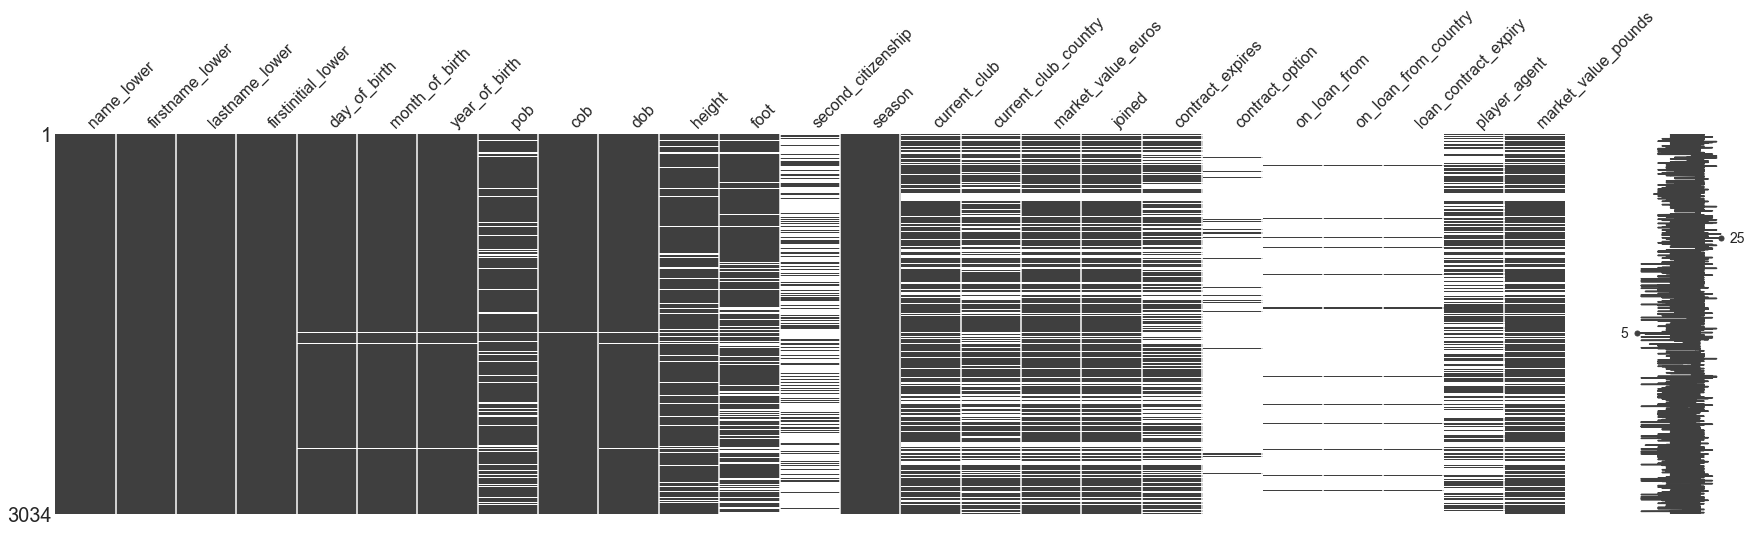

In [120]:
# Plot visualisation of the missing values for each feature of the raw DataFrame, df_tm_player_england_1819
msno.matrix(df_tm_player_england_1819, figsize = (30, 7))

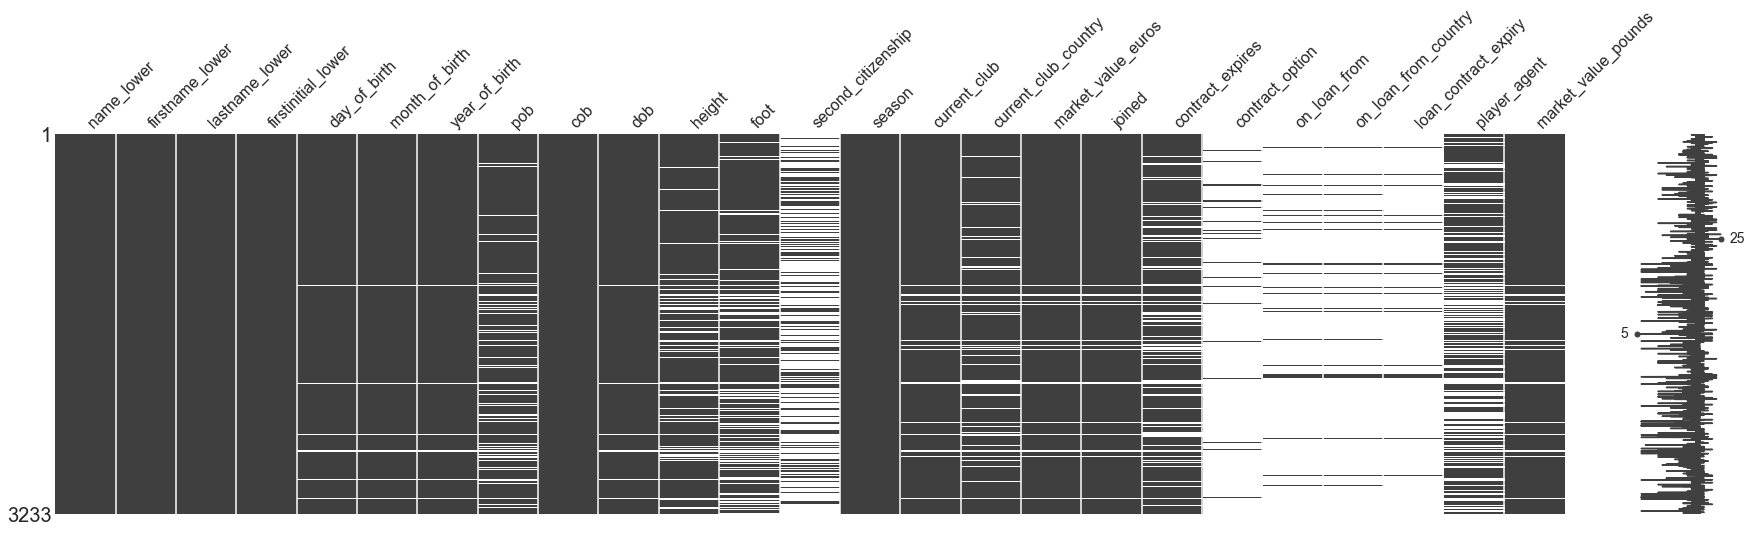

In [121]:
# Plot visualisation of the missing values for each feature of the raw DataFrame, df_tm_player_england_1920
msno.matrix(df_tm_player_england_1920, figsize = (30, 7))

In [122]:
# Counts of missing values
tm_1819_null_value_stats = df_tm_player_england_1819.isnull().sum(axis=0)
tm_1819_null_value_stats[tm_1819_null_value_stats != 0]

day_of_birth              55
month_of_birth            55
year_of_birth             55
pob                      415
cob                        1
dob                       55
height                   379
foot                     645
second_citizenship      2130
current_club             822
current_club_country    1096
market_value_euros       822
joined                   822
contract_expires        1243
contract_option         2887
on_loan_from            2941
on_loan_from_country    2941
loan_contract_expiry    2949
player_agent            1522
market_value_pounds      822
dtype: int64

In [123]:
# Counts of missing values
tm_1920_null_value_stats = df_tm_player_england_1920.isnull().sum(axis=0)
tm_1920_null_value_stats[tm_1819_null_value_stats != 0]

day_of_birth              55
month_of_birth            55
year_of_birth             55
pob                      431
cob                        1
dob                       55
height                   392
foot                     661
second_citizenship      2233
current_club             127
current_club_country     493
market_value_euros       127
joined                   131
contract_expires         714
contract_option         3019
on_loan_from            3058
on_loan_from_country    3058
loan_contract_expiry    3073
player_agent            1169
market_value_pounds      127
dtype: int64

The visualisation shows us very quickly that there a few missing values in the `value` column, but otherwise the dataset is complete.

## <a id='#section4'>4. Data Engineering</a>
Before we answer the questions in the brief through [Exploratory Data Analysis (EDA)](#section5), we'll first need to clean and wrangle the datasets to a form that meet our needs.

### <a id='#section4.1'>4.1. Assign Raw DataFrames to New Engineered DataFrames</a>

In [124]:
# Assign Raw DataFrame to new Engineered DataFrame
df_21stclub = df_21stclub_raw

### <a id='#section4.2'>4.2. String Cleaning</a>

In [125]:
# 
df_21stclub['name_lower'] = df_21stclub['name'].str.normalize('NFKD')\
                                               .str.encode('ascii', errors='ignore')\
                                               .str.decode('utf-8')\
                                               .str.lower()

In [126]:
# First Name Lower
df_21stclub['firstname_lower'] = df_21stclub['name_lower'].str.rsplit(' ', 0).str[0]

# Last Name Lower
df_21stclub['lastname_lower'] = df_21stclub['name_lower'].str.rsplit(' ', 1).str[-1]

# First Initial Lower
df_21stclub['firstinitial_lower'] = df_21stclub['name_lower'].astype(str).str[0]

### <a id='#section4.3'>4.3. Split DataFrames by Season</a>

In [127]:
# Assign df_tm as a new DataFrame - df_21stclub_all, to represent all the players
df_21stclub_all = df_21stclub

# Filter DataFrame for the 2018-2019 season
df_21stclub_1819 = df_21stclub_all[df_21stclub_all['season'] == '2018/2019']

# Filter DataFrame for the 2018-2019 season
df_21stclub_1920 = df_21stclub_all[df_21stclub_all['season'] == '2019/2020']

In [128]:
df_21stclub_all.head()

,season,competition_id,competition,player_id,name,team_id,team,age,nationality,height,...,ground_duels_att,ground_duels_att_won,aerial_duels_def,aerial_duels_def_won,ground_duels_def,ground_duels_def_won,name_lower,firstname_lower,lastname_lower,firstinitial_lower
0,2018/2019,70,Championship,173879,Tamaraebi Abraham,7,Aston Villa,22.0,England,190.0,...,125,59,35,22,40,24,tamaraebi abraham,tamaraebi,abraham,t
1,2018/2019,70,Championship,172649,Dean Henderson,49,Sheffield United,23.0,England,188.0,...,7,7,18,1,0,0,dean henderson,dean,henderson,d
2,2018/2019,70,Championship,108416,John Egan,49,Sheffield United,27.0,Republic of Ireland,185.0,...,21,17,240,82,57,32,john egan,john,egan,j
3,2018/2019,70,Championship,184341,Mason Mount,24,Derby County,21.0,England,178.0,...,106,43,15,10,74,39,mason mount,mason,mount,m
4,2018/2019,70,Championship,146610,Jack O'Connell,49,Sheffield United,26.0,England,190.0,...,29,25,245,73,30,19,jack o'connell,jack,o'connell,j


In [129]:
df_21stclub_1819.head()

,season,competition_id,competition,player_id,name,team_id,team,age,nationality,height,...,ground_duels_att,ground_duels_att_won,aerial_duels_def,aerial_duels_def_won,ground_duels_def,ground_duels_def_won,name_lower,firstname_lower,lastname_lower,firstinitial_lower
0,2018/2019,70,Championship,173879,Tamaraebi Abraham,7,Aston Villa,22.0,England,190.0,...,125,59,35,22,40,24,tamaraebi abraham,tamaraebi,abraham,t
1,2018/2019,70,Championship,172649,Dean Henderson,49,Sheffield United,23.0,England,188.0,...,7,7,18,1,0,0,dean henderson,dean,henderson,d
2,2018/2019,70,Championship,108416,John Egan,49,Sheffield United,27.0,Republic of Ireland,185.0,...,21,17,240,82,57,32,john egan,john,egan,j
3,2018/2019,70,Championship,184341,Mason Mount,24,Derby County,21.0,England,178.0,...,106,43,15,10,74,39,mason mount,mason,mount,m
4,2018/2019,70,Championship,146610,Jack O'Connell,49,Sheffield United,26.0,England,190.0,...,29,25,245,73,30,19,jack o'connell,jack,o'connell,j


In [130]:
df_21stclub_1920.head()

,season,competition_id,competition,player_id,name,team_id,team,age,nationality,height,...,ground_duels_att,ground_duels_att_won,aerial_duels_def,aerial_duels_def_won,ground_duels_def,ground_duels_def_won,name_lower,firstname_lower,lastname_lower,firstinitial_lower
7,2019/2020,70,Championship,178186,Jarrod Bowen,88,Hull City,23.0,England,NaN,...,107,43,10,7,46,20,jarrod bowen,jarrod,bowen,j
14,2019/2020,70,Championship,178301,Ollie Watkins,94,Brentford,24.0,England,180.0,...,122,63,14,8,84,65,ollie watkins,ollie,watkins,o
17,2019/2020,70,Championship,66588,Luke Ayling,2,Leeds United,29.0,England,183.0,...,88,65,126,57,48,16,luke ayling,luke,ayling,l
21,2019/2020,70,Championship,172841,Saïd Benrahma,94,Brentford,25.0,Algeria,172.0,...,171,58,1,1,62,27,said benrahma,said,benrahma,s
23,2019/2020,70,Championship,39790,Kiko Casilla,2,Leeds United,33.0,Spain,190.0,...,4,4,14,1,0,0,kiko casilla,kiko,casilla,k


### <a id='#section4.4'>4.4. Fuzzy Match Datasets - Record Linkage</a>
Now we have our two engineered DataFrames for [21st Club](https://www.21stclub.com/) and [TransferMarkt](https://www.transfermarkt.co.uk/) data, we are now read to merge them to form one dataset.

We are required to join two data sets together that do not have a common unique identifier and are required to use a third-party Python library - [record linkage](https://pypi.org/project/recordlinkage/), installed using pip install recordlinkage. [record linkage](https://pypi.org/project/recordlinkage/) provides a simple interface to link records in or between data sources. 

<b>'Record linkage'</b> is the term used by statisticians, epidemiologists, and historians, among others, to describe the process of joining records from one data source with another that describe the same entity ([source](https://en.wikipedia.org/wiki/Record_linkage)).

Record linkage is necessary when joining different data sets based on entities that may or may not share a common identifier (e.g., database key, URI, National identification number), which may be due to differences in record shape, storage location, or curator style or preference. A data set that has undergone RL-oriented reconciliation may be referred to as being cross-linked. Record linkage is referred to as data linkage in many jurisdictions, but the two are the same process.

The toolkit provides most of the tools needed for record linkage and deduplication. The package contains indexing methods, functions to compare records and classifiers. The package is developed for research and the linking of small or medium sized files.

For a full guide on how to use record linkage, see the official documentation [here](https://recordlinkage.readthedocs.io/en/latest/) and also this worked example by [Chris Moffitt](https://twitter.com/chris1610) [here](https://pbpython.com/record-linking.html)

#### <a id='#section4.4.1'>4.4.1. 2018/19 Season</a>

##### <a id='#section4.4.1'>4.4.1. Join the 2018/19 season Datasets using Record Linkage</a>
The first step is to create a indexer object.

The indexing module is used to make pairs of records. These pairs are called candidate links or candidate matches. There are several indexing algorithms available such as blocking and sorted neighborhood indexing. See the following references for background information about indexation

One key concept is that we can use blocking to limit the number of comparisons. For instance, we know that it is very likely that we only want to compare records that have the same last name, first name initial and birth year. We can use this knowledge to setup a block on these columns in both DataFrames:

In [131]:
df_21stclub_1819.columns

Index(['season', 'competition_id', 'competition', 'player_id', 'name',
       'team_id', 'team', 'age', 'nationality', 'height', 'weight',
       'preferred_foot', 'position', 'detailed_position', 'goals', 'assists',
       'position_am_perc', 'position_cb_perc', 'position_cf_perc',
       'position_cm_perc', 'position_dm_perc', 'position_gk_perc',
       'position_lb_perc', 'position_lw_perc', 'position_rb_perc',
       'position_rw_perc', 'play_time', 'ball_in_play_time', 'shots',
       'shots_open_play', 'shots_open_play_box', 'shots_op_left_foot',
       'shots_op_right_foot', 'shots_op_head', 'crosses', 'crosses_open_play',
       'crosses_op_successful', 'crosses_op_left', 'crosses_op_right',
       'passes', 'passes_open_play', 'passes_op_successful', 'passes_op_head',
       'passes_op_head_successful', 'passes_op_final_third',
       'passes_op_final_third_successful', 'passes_op_box',
       'passes_op_box_successful', 'launches', 'launches_successful',
       'carries', 'ca

In [132]:
df_tm_player_england_1819.columns

Index(['name_lower', 'firstname_lower', 'lastname_lower', 'firstinitial_lower',
       'day_of_birth', 'month_of_birth', 'year_of_birth', 'pob', 'cob', 'dob',
       'height', 'foot', 'second_citizenship', 'season', 'current_club',
       'current_club_country', 'market_value_euros', 'joined',
       'contract_expires', 'contract_option', 'on_loan_from',
       'on_loan_from_country', 'loan_contract_expiry', 'player_agent',
       'market_value_pounds'],
      dtype='object')

In [133]:
# Record Linkage Step 1 - Create an indexer object
indexer = recordlinkage.Index()
indexer.block(left_on = ['firstinitial_lower', 'nationality'], 
              right_on = ['firstinitial_lower', 'cob'])

<Index>

In [134]:
# Record Linkage Step 2 - Build up all the potential candidates to check:
candidates = indexer.index(df_21stclub_1819, df_tm_player_england_1819)
print(len(candidates))

63387


Now that we have defined the left and right data sets and all the candidates, we can define how we want to perform the comparison logic using `Compare()`:

In [135]:
# Record Linkage Step 3 - Define how we to perform the comparison logic
compare = recordlinkage.Compare()

compare.string('firstname_lower',
               'firstname_lower',
               method='levenshtein',
               threshold=0.60,
               label='first_name')
compare.string('lastname_lower',
               'lastname_lower',
               method='levenshtein',
               threshold=0.60,
               label='last_name')

features = compare.compute(candidates, df_21stclub_1819, df_tm_player_england_1819)

View the potential candidates

In [136]:
# Record Linkage Step 4 - view the potential candidates
features

first_name  last_name
0    5            0.0        0.0
     49           0.0        0.0
     50           0.0        0.0
     66           0.0        0.0
     67           0.0        0.0
...               ...        ...
2602 1117         0.0        0.0
     1764         0.0        0.0
     1978         0.0        0.0
     2158         0.0        0.0
2622 2696         0.0        0.0

[63387 rows x 2 columns]

This DataFrame shows the results of all of the comparisons. There is one row for each row in the 21st Century Data and TransferMarkt DataFrames. The columns correspond to the comparisons we defined. A 1 is a match and 0 is not.

Given the large number of records with no matches, it is a little hard to see how many matches we might have. We can sum up the individual scores to see about the quality of the matches.

In [137]:
# Sum up the individual scores to see the quality of the matches.
features.sum(axis=1).value_counts().sort_index(ascending=False)

2.0      488
1.0     9756
0.0    53143
dtype: int64

To only include high-quality matches, let’s just take all the records with 4 matches out of 4 and create a total score column:

In [138]:
# Show records that have match by index number
potential_matches = features[features.sum(axis=1) == 2].reset_index()
potential_matches

,level_0,level_1,first_name,last_name
0,271,620,1.0,1.0
1,319,280,1.0,1.0
2,358,422,1.0,1.0
3,422,798,1.0,1.0
4,422,799,1.0,1.0
...,...,...,...,...
483,1835,313,1.0,1.0
484,1835,314,1.0,1.0
485,1907,885,1.0,1.0
486,1907,2007,1.0,1.0


In [139]:
potential_matches['Score'] = potential_matches.loc[:, 'first_name': 'last_name'].sum(axis=1)

# Display DataFrame of potential matches, potential_matches 
potential_matches

,level_0,level_1,first_name,last_name,Score
0,271,620,1.0,1.0,2.0
1,319,280,1.0,1.0,2.0
2,358,422,1.0,1.0,2.0
3,422,798,1.0,1.0,2.0
4,422,799,1.0,1.0,2.0
...,...,...,...,...,...
483,1835,313,1.0,1.0,2.0
484,1835,314,1.0,1.0,2.0
485,1907,885,1.0,1.0,2.0
486,1907,2007,1.0,1.0,2.0


In [140]:
# Join the 21st Club Outfielder DataFrame to the potential matches DataFrame
df_merge = pd.merge(potential_matches, df_21stclub_1819, left_on='level_0', right_index=True)

# Join the TransferMarkt Outfielder DataFrame to the potential matches DataFrame
df_merge = pd.merge(df_merge, df_tm_player_england_1819, left_on='level_1', right_index=True)

In [141]:
df_merge.columns

Index(['level_0', 'level_1', 'first_name', 'last_name', 'Score', 'season_x',
       'competition_id', 'competition', 'player_id', 'name',
       ...
       'current_club_country', 'market_value_euros', 'joined',
       'contract_expires', 'contract_option', 'on_loan_from',
       'on_loan_from_country', 'loan_contract_expiry', 'player_agent',
       'market_value_pounds'],
      dtype='object', length=104)

df_merge

Now that we've merged the DataFrames, the next step is to clean the DataFrame, reorder the columns, and only keep the columns of interest.

In [142]:
#name_lower_y, firstname_lower_y, lastname_lower_y, firstinitial_lower_y, day_of_birth, month_of_birth, year_of_birth, pob, cob, dob, height_y, foot, second_citizenship, season_y, current_club, current_club_country, market_value_euros, joined, contract_expires, contract_option, on_loan_from, on_loan_from_country, loan_contract_expiry, player_agent, market_value_pounds

In [143]:
# Select columns of interest
cols_merge = ['name_lower_y', 'market_value_euros', 'market_value_pounds', 'day_of_birth', 'month_of_birth', 'year_of_birth', 'pob', 'cob', 'dob', 'second_citizenship', 'current_club', 'current_club_country', 'joined', 'contract_expires', 'contract_option', 'on_loan_from', 'on_loan_from_country', 'loan_contract_expiry', 'player_agent']
#cols_merge = ['name_x', 'name_y', 'playing_country', 'position', 'position_description_grouped', 'value', 'birth_date', 'age_x', 'age_y', 'Score']

# Create more concise DataFrame using only columns of interest
df_merge_select = df_merge[cols_merge]

# Order rows by 'value' and matching 'Score' decending (i.e. best matches of 4 out of 4 at the top) 
df_merge_select = df_merge_select.sort_values(by=['market_value_euros', 'name_lower_y'], ascending=[False, True])

In [144]:
df_merge_select

,name_lower_y,market_value_euros,market_value_pounds,day_of_birth,month_of_birth,year_of_birth,pob,cob,dob,second_citizenship,current_club,current_club_country,joined,contract_expires,contract_option,on_loan_from,on_loan_from_country,loan_contract_expiry,player_agent
84,jarrod bowen,25000000.0,23000000.0,20.0,12.0,1996.0,Leominster,England,1996-12-20,Wales,west ham united,england,31/01/2020,30/06/2025,NaN,NaN,NaN,NaN,PLG
274,kalvin phillips,12000000.0,11040000.0,2.0,12.0,1995.0,Leeds,England,1995-02-12,Jamaica,leeds united,england,01/07/2015,30/06/2024,NaN,NaN,NaN,NaN,NaN
219,ollie watkins,12000000.0,11040000.0,30.0,12.0,1995.0,Torbay,England,1995-12-30,NaN,aston villa,england,09/09/2020,30/06/2025,NaN,NaN,NaN,NaN,Two Touch Agency
249,said benrahma,10500000.0,9660000.0,10.0,8.0,1995.0,Aïn Témouchent,Algeria,1995-10-08,France,brentford fc,england,06/07/2018,30/06/2022,club option 1 year,NaN,NaN,NaN,Unique Sports Management
386,eberechi eze,9000000.0,8280000.0,29.0,6.0,1998.0,London,England,1998-06-29,Nigeria,crystal palace,england,28/08/2020,30/06/2025,NaN,NaN,NaN,NaN,Base Soccer Agency Ltd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,james jones,NaN,NaN,16.0,2.0,1999.0,NaN,England,1999-02-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
107,joe willis,NaN,NaN,NaN,NaN,NaN,NaN,England,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89,joel bagan,NaN,NaN,3.0,9.0,2001.0,NaN,England,2001-03-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50,matt smith,NaN,NaN,22.0,11.0,1999.0,Redditch,England,1999-11-22,England,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [145]:
# Join the Company House DataFrame to the potential matches DataFrame
df_final = pd.merge(df_21stclub_1819, df_merge_select, left_on='name_lower', right_on='name_lower_y', how='left')

In [146]:
df_final

,season,competition_id,competition,player_id,name,team_id,team,age,nationality,height,...,second_citizenship,current_club,current_club_country,joined,contract_expires,contract_option,on_loan_from,on_loan_from_country,loan_contract_expiry,player_agent
0,2018/2019,70,Championship,173879,Tamaraebi Abraham,7,Aston Villa,22.0,England,190.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018/2019,70,Championship,172649,Dean Henderson,49,Sheffield United,23.0,England,188.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018/2019,70,Championship,108416,John Egan,49,Sheffield United,27.0,Republic of Ireland,185.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018/2019,70,Championship,184341,Mason Mount,24,Derby County,21.0,England,178.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018/2019,70,Championship,146610,Jack O'Connell,49,Sheffield United,26.0,England,190.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
776,2018/2019,70,Championship,153373,Sam McQueen,25,Middlesbrough,25.0,England,180.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
777,2018/2019,70,Championship,193112,William Huffer,2,Leeds United,21.0,England,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
778,2018/2019,70,Championship,221824,Lewis Walker,52,Queens Park Rangers,22.0,England,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
779,2018/2019,70,Championship,209412,Ryan East,108,Reading,22.0,England,NaN,...,NaN,reading fc,england,01/07/2019,30/06/2021,NaN,NaN,NaN,NaN,PIR


In [147]:
df_final.columns

Index(['season', 'competition_id', 'competition', 'player_id', 'name',
       'team_id', 'team', 'age', 'nationality', 'height', 'weight',
       'preferred_foot', 'position', 'detailed_position', 'goals', 'assists',
       'position_am_perc', 'position_cb_perc', 'position_cf_perc',
       'position_cm_perc', 'position_dm_perc', 'position_gk_perc',
       'position_lb_perc', 'position_lw_perc', 'position_rb_perc',
       'position_rw_perc', 'play_time', 'ball_in_play_time', 'shots',
       'shots_open_play', 'shots_open_play_box', 'shots_op_left_foot',
       'shots_op_right_foot', 'shots_op_head', 'crosses', 'crosses_open_play',
       'crosses_op_successful', 'crosses_op_left', 'crosses_op_right',
       'passes', 'passes_open_play', 'passes_op_successful', 'passes_op_head',
       'passes_op_head_successful', 'passes_op_final_third',
       'passes_op_final_third_successful', 'passes_op_box',
       'passes_op_box_successful', 'launches', 'launches_successful',
       'carries', 'ca

In [148]:
# Select columns of interest
cols_final = ['season', 'competition_id', 'competition', 'player_id', 'name', 'name_lower_y',
       'market_value_euros', 'market_value_pounds', 'team_id', 'team', 'age', 'nationality', 'second_citizenship',
       'height', 'weight', 'preferred_foot', 'position', 'detailed_position', 'goals', 'assists',
       'position_am_perc', 'position_cb_perc', 'position_cf_perc',
       'position_cm_perc', 'position_dm_perc', 'position_gk_perc',
       'position_lb_perc', 'position_lw_perc', 'position_rb_perc',
       'position_rw_perc', 'play_time', 'ball_in_play_time', 'shots',
       'shots_open_play', 'shots_open_play_box', 'shots_op_left_foot',
       'shots_op_right_foot', 'shots_op_head', 'crosses', 'crosses_open_play',
       'crosses_op_successful', 'crosses_op_left', 'crosses_op_right',
       'passes', 'passes_open_play', 'passes_op_successful', 'passes_op_head',
       'passes_op_head_successful', 'passes_op_final_third',
       'passes_op_final_third_successful', 'passes_op_box',
       'passes_op_box_successful', 'launches', 'launches_successful',
       'carries', 'carries_box', 'carry_distance', 'dribbles',
       'dribbles_successful', 'dribbles_box', 'recoveries', 'tackles',
       'interceptions', 'blocks', 'clearances', 'saves', 'aerial_duels_att',
       'aerial_duels_att_won', 'ground_duels_att', 'ground_duels_att_won',
       'aerial_duels_def', 'aerial_duels_def_won', 'ground_duels_def',
       'ground_duels_def_won', 'day_of_birth',
       'month_of_birth', 'year_of_birth', 'pob', 'cob', 'dob',
        'current_club', 'current_club_country', 'joined',
       'contract_expires', 'contract_option', 'on_loan_from',
       'on_loan_from_country', 'loan_contract_expiry', 'player_agent']

# Create more concise DataFrame using only columns of interest
df_final = df_final[cols_final]

# Order rows by matching score decending and name ascending (alphabetically) - i.e. best matches of 5 out of 5 at the top) 
df_final = df_final.sort_values(by=['market_value_euros', 'name'], ascending=[False, True])

In [149]:
df_final.shape

(781, 89)

In [150]:
df_final

,season,competition_id,competition,player_id,name,name_lower_y,market_value_euros,market_value_pounds,team_id,team,...,dob,current_club,current_club_country,joined,contract_expires,contract_option,on_loan_from,on_loan_from_country,loan_contract_expiry,player_agent
6,2018/2019,70,Championship,178186,Jarrod Bowen,jarrod bowen,25000000.0,23000000.0,88,Hull City,...,1996-12-20,west ham united,england,31/01/2020,30/06/2025,NaN,NaN,NaN,NaN,PLG
22,2018/2019,70,Championship,155405,Kalvin Phillips,kalvin phillips,12000000.0,11040000.0,2,Leeds United,...,1995-02-12,leeds united,england,01/07/2015,30/06/2024,NaN,NaN,NaN,NaN,NaN
12,2018/2019,70,Championship,178301,Ollie Watkins,ollie watkins,12000000.0,11040000.0,94,Brentford,...,1995-12-30,aston villa,england,09/09/2020,30/06/2025,NaN,NaN,NaN,NaN,Two Touch Agency
17,2018/2019,70,Championship,172841,Saïd Benrahma,said benrahma,10500000.0,9660000.0,94,Brentford,...,1995-10-08,brentford fc,england,06/07/2018,30/06/2022,club option 1 year,NaN,NaN,NaN,Unique Sports Management
106,2018/2019,70,Championship,232413,Eberechi Eze,eberechi eze,9000000.0,8280000.0,52,Queens Park Rangers,...,1998-06-29,crystal palace,england,28/08/2020,30/06/2025,NaN,NaN,NaN,NaN,Base Soccer Agency Ltd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,2018/2019,70,Championship,87333,Yanic Wildschut,NaN,NaN,NaN,30,Bolton Wanderers,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
80,2018/2019,70,Championship,55452,Yannick Bolasie,NaN,NaN,NaN,7,Aston Villa,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
359,2018/2019,70,Championship,86364,Yennaris Nico,NaN,NaN,NaN,94,Brentford,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
395,2018/2019,70,Championship,41321,Yohan Benalouane,NaN,NaN,NaN,17,Nottingham Forest,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [151]:
df_final_dedupe_1819 = df_final.drop_duplicates()

In [152]:
df_final_dedupe_1819.shape

(641, 89)

In [153]:
df_null_1819 = df_final_dedupe_1819[df_final_dedupe_1819['market_value_euros'].isnull()]

In [154]:
df_null_1819

,season,competition_id,competition,player_id,name,name_lower_y,market_value_euros,market_value_pounds,team_id,team,...,dob,current_club,current_club_country,joined,contract_expires,contract_option,on_loan_from,on_loan_from_country,loan_contract_expiry,player_agent
665,2018/2019,70,Championship,79479,Achraf Lazaar,NaN,NaN,NaN,19,Sheffield Wednesday,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43,2018/2019,70,Championship,110735,Adam Webster,NaN,NaN,NaN,113,Bristol City,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
715,2018/2019,70,Championship,169128,Adetayo Edun,NaN,NaN,NaN,40,Ipswich Town,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
742,2018/2019,70,Championship,44302,Adlène Guédioura,NaN,NaN,NaN,17,Nottingham Forest,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
251,2018/2019,70,Championship,37339,Ahmed El Mohamady,NaN,NaN,NaN,7,Aston Villa,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,2018/2019,70,Championship,87333,Yanic Wildschut,NaN,NaN,NaN,30,Bolton Wanderers,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
80,2018/2019,70,Championship,55452,Yannick Bolasie,NaN,NaN,NaN,7,Aston Villa,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
359,2018/2019,70,Championship,86364,Yennaris Nico,NaN,NaN,NaN,94,Brentford,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
395,2018/2019,70,Championship,41321,Yohan Benalouane,NaN,NaN,NaN,17,Nottingham Forest,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Export the 18/19 DataFrame>

In [155]:
# Export the three DataFrames
df_final_dedupe_1819.to_csv(data_dir_21st_club_tm + '/raw/1819/' + f'tm_player_efl_1819_last_updated_{today}.csv', index=None, header=True)

##### <a id='#section4.4.2'>4.4.2. Join the 2019/20 season Datasets using Record Linkage</a>
Create the indexer object.

In [156]:
# Record Linkage Step 1 - Create an indexer object
indexer = recordlinkage.Index()
indexer.block(left_on = ['firstinitial_lower', 'nationality'], 
              right_on = ['firstinitial_lower', 'cob'])

<Index>

The next step is to build up all the potential candidates to check:

In [157]:
# Record Linkage Step 2 - Build up all the potential candidates to check:
candidates = indexer.index(df_21stclub_1920, df_tm_player_england_1920)
print(len(candidates))

251674


Now that we have defined the left and right data sets and all the candidates, we can define how we want to perform the comparison logic using `Compare()`:

In [158]:
# Record Linkage Step 3 - Define how we to perform the comparison logic
compare = recordlinkage.Compare()

compare.string('firstname_lower',
               'firstname_lower',
               method='levenshtein',
               threshold=0.60,
               label='first_name')
compare.string('lastname_lower',
               'lastname_lower',
               method='levenshtein',
               threshold=0.60,
               label='last_name')

features = compare.compute(candidates, df_21stclub_1920, df_tm_player_england_1920)

View the potential candidates

In [159]:
# Record Linkage Step 4 - view the potential candidates
features

first_name  last_name
7    10           0.0        0.0
     12           0.0        0.0
     25           0.0        0.0
     28           0.0        0.0
     29           0.0        0.0
...               ...        ...
2539 551          0.0        0.0
     2424         1.0        1.0
     3074         0.0        0.0
2595 245          1.0        0.0
     403          1.0        1.0

[251674 rows x 2 columns]

This DataFrame shows the results of all of the comparisons. There is one row for each row in the 21st Century Data and TransferMarkt DataFrames. The columns correspond to the comparisons we defined. A 1 is a match and 0 is not.

Given the large number of records with no matches, it is a little hard to see how many matches we might have. We can sum up the individual scores to see about the quality of the matches.

In [160]:
# Sum up the individual scores to see the quality of the matches.
features.sum(axis=1).value_counts().sort_index(ascending=False)

2.0      2401
1.0     37865
0.0    211408
dtype: int64

To only include high-quality matches, let’s just take all the records with 4 matches out of 4 and create a total score column:

In [161]:
# Show records that have match by index number
potential_matches = features[features.sum(axis=1) == 2].reset_index()
potential_matches

,level_0,level_1,first_name,last_name
0,7,888,1.0,1.0
1,53,1055,1.0,1.0
2,64,25,1.0,1.0
3,70,164,1.0,1.0
4,90,96,1.0,1.0
...,...,...,...,...
2396,2495,2744,1.0,1.0
2397,2501,2466,1.0,1.0
2398,2508,3032,1.0,1.0
2399,2539,2424,1.0,1.0


In [162]:
potential_matches['Score'] = potential_matches.loc[:, 'first_name': 'last_name'].sum(axis=1)

# Display DataFrame of potential matches, potential_matches 
potential_matches

,level_0,level_1,first_name,last_name,Score
0,7,888,1.0,1.0,2.0
1,53,1055,1.0,1.0,2.0
2,64,25,1.0,1.0,2.0
3,70,164,1.0,1.0,2.0
4,90,96,1.0,1.0,2.0
...,...,...,...,...,...
2396,2495,2744,1.0,1.0,2.0
2397,2501,2466,1.0,1.0,2.0
2398,2508,3032,1.0,1.0,2.0
2399,2539,2424,1.0,1.0,2.0


In [163]:
# Join the 21st Club Outfielder DataFrame to the potential matches DataFrame
df_merge = pd.merge(potential_matches, df_21stclub_1920, left_on='level_0', right_index=True)

# Join the TransferMarkt Outfielder DataFrame to the potential matches DataFrame
df_merge = pd.merge(df_merge, df_tm_player_england_1920, left_on='level_1', right_index=True)

In [164]:
df_merge.columns

Index(['level_0', 'level_1', 'first_name', 'last_name', 'Score', 'season_x',
       'competition_id', 'competition', 'player_id', 'name',
       ...
       'current_club_country', 'market_value_euros', 'joined',
       'contract_expires', 'contract_option', 'on_loan_from',
       'on_loan_from_country', 'loan_contract_expiry', 'player_agent',
       'market_value_pounds'],
      dtype='object', length=104)

In [165]:
df_merge

,level_0,level_1,first_name,last_name,Score,season_x,competition_id,competition,player_id,name,...,current_club_country,market_value_euros,joined,contract_expires,contract_option,on_loan_from,on_loan_from_country,loan_contract_expiry,player_agent,market_value_pounds
0,7,888,1.0,1.0,2.0,2019/2020,70,Championship,178186,Jarrod Bowen,...,england,25000000.0,2020-01-31,2025-06-30,NaN,NaN,NaN,NaN,PLG,23000000.0
1,53,1055,1.0,1.0,2.0,2019/2020,70,Championship,49944,Jake Livermore,...,england,5500000.0,2017-01-20,2022-06-30,NaN,NaN,NaN,NaN,not clarified,5060000.0
2,64,25,1.0,1.0,2.0,2019/2020,70,Championship,221399,Jack Harrison,...,england,5200000.0,2020-08-10,2022-06-30,NaN,manchester city,england,2021-05-31,Remington Cherin,4784000.0
3,70,164,1.0,1.0,2.0,2019/2020,70,Championship,167895,Jake Cooper,...,england,2800000.0,2017-07-28,2023-06-30,NaN,NaN,NaN,NaN,NaN,2576000.0
4,90,96,1.0,1.0,2.0,2019/2020,70,Championship,208912,Joe Worrall,...,england,400000.0,2017-07-01,2021-06-30,NaN,NaN,NaN,NaN,Stellar Football Ltd,368000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2396,2495,2744,1.0,1.0,2.0,2019/2020,32,League Two,42725,Elliot Grandin,...,NaN,150000.0,2020-07-01,NaN,NaN,NaN,NaN,NaN,no agent,138000.0
2397,2501,2466,1.0,1.0,2.0,2019/2020,32,League Two,119149,Brice Ntambwe,...,NaN,225000.0,2020-01-03,NaN,NaN,NaN,NaN,NaN,no agent,207000.0
2398,2508,3032,1.0,1.0,2.0,2019/2020,32,League Two,442245,Klaidi Lolos,...,england,0.0,2019-07-01,2021-06-30,NaN,NaN,NaN,NaN,P4P Sports Management,0.0
2399,2539,2424,1.0,1.0,2.0,2019/2020,32,League Two,175541,Sacha Bastien,...,NaN,150000.0,2020-07-01,NaN,NaN,NaN,NaN,NaN,RT Management & Consultancy,138000.0


Now that we've merged the DataFrames, the next step is to clean the DataFrame, reorder the columns, and only keep the columns of interest.

In [166]:
# Select columns of interest
cols_merge = ['name_lower_y', 'market_value_euros', 'market_value_pounds', 'day_of_birth', 'month_of_birth', 'year_of_birth', 'pob', 'cob', 'dob', 'second_citizenship', 'current_club', 'current_club_country', 'joined', 'contract_expires', 'contract_option', 'on_loan_from', 'on_loan_from_country', 'loan_contract_expiry', 'player_agent']
#cols_merge = ['name_x', 'name_y', 'playing_country', 'position', 'position_description_grouped', 'value', 'birth_date', 'age_x', 'age_y', 'Score']

# Create more concise DataFrame using only columns of interest
df_merge_select = df_merge[cols_merge]

# Order rows by 'value' and matching 'Score' decending (i.e. best matches of 4 out of 4 at the top) 
df_merge_select = df_merge_select.sort_values(by=['market_value_euros', 'name_lower_y'], ascending=[False, True])

In [167]:
df_merge_select

,name_lower_y,market_value_euros,market_value_pounds,day_of_birth,month_of_birth,year_of_birth,pob,cob,dob,second_citizenship,current_club,current_club_country,joined,contract_expires,contract_option,on_loan_from,on_loan_from_country,loan_contract_expiry,player_agent
86,jude bellingham,27000000.0,24840000.0,29.0,6.0,2003.0,Stourbridge,England,2003-06-29,NaN,borussia dortmund,germany,2020-07-23,2023-06-30,NaN,NaN,NaN,NaN,NaN
0,jarrod bowen,25000000.0,23000000.0,20.0,12.0,1996.0,Leominster,England,1996-12-20,Wales,west ham united,england,2020-01-31,2025-06-30,NaN,NaN,NaN,NaN,PLG
705,kalvin phillips,12000000.0,11040000.0,2.0,12.0,1995.0,Leeds,England,1995-12-02,Jamaica,leeds united,england,2015-07-01,2024-06-30,NaN,NaN,NaN,NaN,NaN
438,ollie watkins,12000000.0,11040000.0,30.0,12.0,1995.0,Torbay,England,1995-12-30,NaN,aston villa,england,2020-09-09,2025-06-30,NaN,NaN,NaN,NaN,Two Touch Agency
597,said benrahma,10500000.0,9660000.0,10.0,8.0,1995.0,Aïn Témouchent,Algeria,1995-08-10,France,brentford fc,england,2018-07-06,2022-06-30,club option 1 year,NaN,NaN,NaN,Unique Sports Management
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1926,terrell egbri,NaN,NaN,21.0,6.0,2001.0,NaN,England,2001-06-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1903,tyler smith,NaN,NaN,4.0,12.0,1998.0,Sheffield,England,1998-12-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1905,tyler smith,NaN,NaN,4.0,12.0,1998.0,Sheffield,England,1998-12-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1904,tyler smith,NaN,NaN,4.0,12.0,1998.0,Sheffield,England,1998-12-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [168]:
# Join the Company House DataFrame to the potential matches DataFrame
df_final = pd.merge(df_21stclub_1920, df_merge_select, left_on='name_lower', right_on='name_lower_y', how='left')

In [169]:
df_final

,season,competition_id,competition,player_id,name,team_id,team,age,nationality,height,...,second_citizenship,current_club,current_club_country,joined,contract_expires,contract_option,on_loan_from,on_loan_from_country,loan_contract_expiry,player_agent
0,2019/2020,70,Championship,178186,Jarrod Bowen,88,Hull City,23.0,England,NaN,...,Wales,west ham united,england,2020-01-31,2025-06-30,NaN,NaN,NaN,NaN,PLG
1,2019/2020,70,Championship,178301,Ollie Watkins,94,Brentford,24.0,England,180.0,...,NaN,aston villa,england,2020-09-09,2025-06-30,NaN,NaN,NaN,NaN,Two Touch Agency
2,2019/2020,70,Championship,66588,Luke Ayling,2,Leeds United,29.0,England,183.0,...,NaN,leeds united,england,2016-08-11,2023-06-30,NaN,NaN,NaN,NaN,Stellar Football Ltd
3,2019/2020,70,Championship,172841,Saïd Benrahma,94,Brentford,25.0,Algeria,172.0,...,France,brentford fc,england,2018-07-06,2022-06-30,club option 1 year,NaN,NaN,NaN,Unique Sports Management
4,2019/2020,70,Championship,39790,Kiko Casilla,2,Leeds United,33.0,Spain,190.0,...,NaN,leeds united,england,2019-01-17,2023-06-30,NaN,NaN,NaN,NaN,CONTROL ORIENTADO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3607,2019/2020,32,League Two,115832,Jackson Longridge,55,Bradford City,25.0,Scotland,183.0,...,NaN,bradford city,england,2019-07-01,2021-06-30,NaN,NaN,NaN,NaN,14 Sports Management
3608,2019/2020,70,Championship,198847,Bright Enobakhare,111,Wigan Athletic,22.0,Nigeria,178.0,...,England,aek athens,greece,2020-08-03,2023-06-30,NaN,NaN,NaN,NaN,RDF Football
3609,2019/2020,32,League Two,488713,Andre Hasanally,99,Colchester United,18.0,England,NaN,...,NaN,colchester united u23,england,2019-08-30,2022-06-30,NaN,NaN,NaN,NaN,NaN
3610,2019/2020,32,League Two,223827,Daniel Ballard,46,Swindon Town,20.0,Northern Ireland,187.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [170]:
df_final.columns

Index(['season', 'competition_id', 'competition', 'player_id', 'name',
       'team_id', 'team', 'age', 'nationality', 'height', 'weight',
       'preferred_foot', 'position', 'detailed_position', 'goals', 'assists',
       'position_am_perc', 'position_cb_perc', 'position_cf_perc',
       'position_cm_perc', 'position_dm_perc', 'position_gk_perc',
       'position_lb_perc', 'position_lw_perc', 'position_rb_perc',
       'position_rw_perc', 'play_time', 'ball_in_play_time', 'shots',
       'shots_open_play', 'shots_open_play_box', 'shots_op_left_foot',
       'shots_op_right_foot', 'shots_op_head', 'crosses', 'crosses_open_play',
       'crosses_op_successful', 'crosses_op_left', 'crosses_op_right',
       'passes', 'passes_open_play', 'passes_op_successful', 'passes_op_head',
       'passes_op_head_successful', 'passes_op_final_third',
       'passes_op_final_third_successful', 'passes_op_box',
       'passes_op_box_successful', 'launches', 'launches_successful',
       'carries', 'ca

In [171]:
# Select columns of interest
cols_final = ['season', 'competition_id', 'competition', 'player_id', 'name', 'name_lower_y',
       'market_value_euros', 'market_value_pounds', 'team_id', 'team', 'age', 'nationality', 'second_citizenship',
       'height', 'weight', 'preferred_foot', 'position', 'detailed_position', 'goals', 'assists',
       'position_am_perc', 'position_cb_perc', 'position_cf_perc',
       'position_cm_perc', 'position_dm_perc', 'position_gk_perc',
       'position_lb_perc', 'position_lw_perc', 'position_rb_perc',
       'position_rw_perc', 'play_time', 'ball_in_play_time', 'shots',
       'shots_open_play', 'shots_open_play_box', 'shots_op_left_foot',
       'shots_op_right_foot', 'shots_op_head', 'crosses', 'crosses_open_play',
       'crosses_op_successful', 'crosses_op_left', 'crosses_op_right',
       'passes', 'passes_open_play', 'passes_op_successful', 'passes_op_head',
       'passes_op_head_successful', 'passes_op_final_third',
       'passes_op_final_third_successful', 'passes_op_box',
       'passes_op_box_successful', 'launches', 'launches_successful',
       'carries', 'carries_box', 'carry_distance', 'dribbles',
       'dribbles_successful', 'dribbles_box', 'recoveries', 'tackles',
       'interceptions', 'blocks', 'clearances', 'saves', 'aerial_duels_att',
       'aerial_duels_att_won', 'ground_duels_att', 'ground_duels_att_won',
       'aerial_duels_def', 'aerial_duels_def_won', 'ground_duels_def',
       'ground_duels_def_won', 'day_of_birth',
       'month_of_birth', 'year_of_birth', 'pob', 'cob', 'dob',
        'current_club', 'current_club_country', 'joined',
       'contract_expires', 'contract_option', 'on_loan_from',
       'on_loan_from_country', 'loan_contract_expiry', 'player_agent']

# Create more concise DataFrame using only columns of interest
df_final = df_final[cols_final]

# Order rows by matching score decending and name ascending (alphabetically) - i.e. best matches of 5 out of 5 at the top) 
df_final = df_final.sort_values(by=['market_value_euros', 'name'], ascending=[False, True])

In [172]:
df_final.shape

(3612, 89)

In [173]:
df_final

,season,competition_id,competition,player_id,name,name_lower_y,market_value_euros,market_value_pounds,team_id,team,...,dob,current_club,current_club_country,joined,contract_expires,contract_option,on_loan_from,on_loan_from_country,loan_contract_expiry,player_agent
839,2019/2020,70,Championship,244855,Jude Bellingham,jude bellingham,27000000.0,24840000.0,41,Birmingham City,...,2003-06-29,borussia dortmund,germany,2020-07-23,2023-06-30,NaN,NaN,NaN,NaN,NaN
0,2019/2020,70,Championship,178186,Jarrod Bowen,jarrod bowen,25000000.0,23000000.0,88,Hull City,...,1996-12-20,west ham united,england,2020-01-31,2025-06-30,NaN,NaN,NaN,NaN,PLG
7,2019/2020,70,Championship,155405,Kalvin Phillips,kalvin phillips,12000000.0,11040000.0,2,Leeds United,...,1995-12-02,leeds united,england,2015-07-01,2024-06-30,NaN,NaN,NaN,NaN,NaN
1,2019/2020,70,Championship,178301,Ollie Watkins,ollie watkins,12000000.0,11040000.0,94,Brentford,...,1995-12-30,aston villa,england,2020-09-09,2025-06-30,NaN,NaN,NaN,NaN,Two Touch Agency
3,2019/2020,70,Championship,172841,Saïd Benrahma,said benrahma,10500000.0,9660000.0,94,Brentford,...,1995-08-10,brentford fc,england,2018-07-06,2022-06-30,club option 1 year,NaN,NaN,NaN,Unique Sports Management
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2183,2019/2020,32,League Two,82459,Zachary Mills,NaN,NaN,NaN,105,Oldham Athletic,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3184,2019/2020,32,League Two,179263,Zak Jules,NaN,NaN,NaN,42,Walsall,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3097,2019/2020,32,League Two,109640,Zeli Ismail,NaN,NaN,NaN,55,Bradford City,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3311,2019/2020,32,League Two,172860,Zeus de la Paz,NaN,NaN,NaN,105,Oldham Athletic,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [174]:
df_final_dedupe_1920 = df_final.drop_duplicates()

In [175]:
df_final_dedupe_1920.shape

(2014, 89)

In [176]:
df_null_1920 = df_final_dedupe_1920[df_final_dedupe_1920['market_value_euros'].isnull()]

In [177]:
df_null_1920

,season,competition_id,competition,player_id,name,name_lower_y,market_value_euros,market_value_pounds,team_id,team,...,dob,current_club,current_club_country,joined,contract_expires,contract_option,on_loan_from,on_loan_from_country,loan_contract_expiry,player_agent
1024,2019/2020,15,League One,143674,Aaron Pierre,NaN,NaN,NaN,74,Shrewsbury Town,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1309,2019/2020,70,Championship,104074,Abdulyussuf Oshilaja,NaN,NaN,NaN,33,Charlton Athletic,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2398,2019/2020,32,League Two,428061,Abobaker Eisa,NaN,NaN,NaN,93,Scunthorpe United,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1423,2019/2020,15,League One,56860,Abumere Ogogo,NaN,NaN,NaN,96,Bristol Rovers,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2034,2019/2020,15,League One,51449,Adam Chicksen,NaN,NaN,NaN,30,Bolton Wanderers,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2183,2019/2020,32,League Two,82459,Zachary Mills,NaN,NaN,NaN,105,Oldham Athletic,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3184,2019/2020,32,League Two,179263,Zak Jules,NaN,NaN,NaN,42,Walsall,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3097,2019/2020,32,League Two,109640,Zeli Ismail,NaN,NaN,NaN,55,Bradford City,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3311,2019/2020,32,League Two,172860,Zeus de la Paz,NaN,NaN,NaN,105,Oldham Athletic,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Export the DataFrame

In [178]:
# Export the three DataFrames
df_final_dedupe_1920.to_csv(data_dir_21st_club_tm + '/raw/1920/' + f'tm_player_efl_1920_last_updated_{today}.csv', index=None, header=True)

### <a id='#section4.5'>4.5. Join DataFrames</a>

In [179]:
df_tm_efl_1819_1920 = pd.concat([df_final_dedupe_1819, df_final_dedupe_1920], axis=0)

In [180]:
# Export the three DataFrames
df_tm_efl_1819_1920.to_csv(data_dir_21st_club_tm + '/raw/combined/' + f'tm_player_efl_1819_1920_last_updated_{today}.csv', index=None, header=True)

In [181]:
df_tm_efl_1819_1920.head()

,season,competition_id,competition,player_id,name,name_lower_y,market_value_euros,market_value_pounds,team_id,team,...,dob,current_club,current_club_country,joined,contract_expires,contract_option,on_loan_from,on_loan_from_country,loan_contract_expiry,player_agent
6,2018/2019,70,Championship,178186,Jarrod Bowen,jarrod bowen,25000000.0,23000000.0,88,Hull City,...,1996-12-20,west ham united,england,31/01/2020,30/06/2025,NaN,NaN,NaN,NaN,PLG
22,2018/2019,70,Championship,155405,Kalvin Phillips,kalvin phillips,12000000.0,11040000.0,2,Leeds United,...,1995-02-12,leeds united,england,01/07/2015,30/06/2024,NaN,NaN,NaN,NaN,NaN
12,2018/2019,70,Championship,178301,Ollie Watkins,ollie watkins,12000000.0,11040000.0,94,Brentford,...,1995-12-30,aston villa,england,09/09/2020,30/06/2025,NaN,NaN,NaN,NaN,Two Touch Agency
17,2018/2019,70,Championship,172841,Saïd Benrahma,said benrahma,10500000.0,9660000.0,94,Brentford,...,1995-10-08,brentford fc,england,06/07/2018,30/06/2022,club option 1 year,NaN,NaN,NaN,Unique Sports Management
106,2018/2019,70,Championship,232413,Eberechi Eze,eberechi eze,9000000.0,8280000.0,52,Queens Park Rangers,...,1998-06-29,crystal palace,england,28/08/2020,30/06/2025,NaN,NaN,NaN,NaN,Base Soccer Agency Ltd


In [182]:
df_tm_efl_1819_1920.shape

(2655, 89)

### <a id='#section4.6'>4.6. Create New Metrics</a>
As part of the data analysis, many of the metrics need to be standardised or used to derive new metrics.

For Full-Backs, the 12 metrics that are assessed are: 
- `tackles_p90` = `tackles` / `p90`
- `interceptions_p90` = `interceptions` / `p90`
- `recoveries_p90` = `recoveries` / `p90`
- `deep_progressions_p90` = (`pass_op_box` + `dribbles_box` + `carries_box`) / `p90`
- `blocks_p90` = `blocks` / `p90`
- `carries_p90` = `carries` / `p90`
- `passing_op_%` = (`pass_op_box_successful` + `pass_op_final_third_successful` + `pass_op_head_successful`) / (`pass_op_box` + `pass_op_final_third` + `pass_op_head`)
- `dribbles_%` = `dribbles_successful` / `dribbles`
- `launches_%` = `launches_successful` / `launches`
- `aerial_duels_%` = (`aerial_duels_att_won` + `aerial_duels_def_won`) / (`aerial_duels_att` + `aerial_duels_def`)
- `ground_duels_%` = (`ground_duels_att_won` + `ground_duels_def_won`) / (`ground_duels_att` + `ground_duels_def`)
- `crosses_op_%` = `crosses_op_successful` / (`crosses_op_left` + `crosses_op_right`)

For Wingers, the 12 metrics that are assessed are: 
- `goals_per_shot` = `goals` / `shots`
- `goals_p90` = `goals` / `p90`
- `shots_p90` = `shots` / `p90`
- `assists_p90` = `assists` / `p90`
- `interceptions_p90` = `interceptions` / `p90`
- `deep_progressions_p90` = (`pass_op_box` + `dribbles_box` + `carries_box`) / `p90`
- `carry_distance_p90` = `carry_distance` / `p90`
- `dribbles %` = `dribbles_successful` / `dribbles`
- `crosses_op_%` = `crosses_op_successful` / (`crosses_op_left` + `crosses_op_right`)
- `passing_op_%` = (`pass_op_box_successful` + `pass_op_final_third_successful` + `pass_op_head_successful`) / (`pass_op_box` + `pass_op_final_third` + `pass_op_head`)
- `pass_op_box_%` = `pass_op_box` / `pass_op_box_successful`


Where `p90` is a calculated field of `play_time` / 90

In total, this requires the creation of 19 new metrics, as follows (in alphabetically):
- `aerial_duels_%` = (`aerial_duels_att_won` + `aerial_duels_def_won`) / (`aerial_duels_att` + `aerial_duels_def`)
- `assists_p90` = `assists` / `p90`
- `blocks_p90` = `blocks` / `p90`
- `carries_p90` = `carries` / `p90`
- `carries_box_p90` = `carries_box` / `p90`
- `carry_distance_p90` = `carry_distance` / `p90`
- `crosses_op_%` = `crosses_op_successful` / (`crosses_op_left` + `crosses_op_right`)
- `deep_progressions_p90` = (`pass_op_box` + `dribbles_box` + `carries_box`) / `p90`
- `dribbles %` = `dribbles_successful` / `dribbles`
- `goals_p90` = `goals` / `p90`
- `goals_per_shot` = `goals` / `shots`
- `ground_duels_%` = (`ground_duels_att_won` + `ground_duels_def_won`) / (`ground_duels_att` + `ground_duels_def`)
- `interceptions_p90` = `interceptions` / `p90`
- `launches %` = `launches_successful` / `launches`
- `passing_op_%` = (`pass_op_box_successful` + `pass_op_final_third_successful` + `pass_op_head_successful`) / (`pass_op_box` + `pass_op_final_third` + `pass_op_head`)
- `pass_op_box_%` = `pass_op_box` / `pass_op_box_successful`
- `recoveries_p90` = `recoveries` / `p90`
- `shots_p90` = `shots` / `p90`
- `tackles_p90` = `tackles` / `p90`

In [202]:
# Creation of new metrics

## Creation of p90 metric used to standardise all metrics
df_tm_efl_1819_1920['p90'] = df_tm_efl_1819_1920['play_time'] / 90

## Creation of 19 new metrics used in analysis of full-backs and wingers
df_tm_efl_1819_1920['aerial_duels_%'] = (df_tm_efl_1819_1920['aerial_duels_att_won'] + df_tm_efl_1819_1920['aerial_duels_def_won']) / (df_tm_efl_1819_1920['aerial_duels_att'] + df_tm_efl_1819_1920['aerial_duels_def'])
df_tm_efl_1819_1920['assists_p90'] = df_tm_efl_1819_1920['assists'] / df_tm_efl_1819_1920['p90']
df_tm_efl_1819_1920['blocks_p90'] = df_tm_efl_1819_1920['blocks'] / df_tm_efl_1819_1920['p90']
df_tm_efl_1819_1920['carries_p90'] = df_tm_efl_1819_1920['carries'] / df_tm_efl_1819_1920['p90']
df_tm_efl_1819_1920['carries_box_p90'] = df_tm_efl_1819_1920['carries_box'] / df_tm_efl_1819_1920['p90']
df_tm_efl_1819_1920['carry_distance_p90'] = df_tm_efl_1819_1920['carry_distance'] / df_tm_efl_1819_1920['p90']
df_tm_efl_1819_1920['crosses_op_%'] = df_tm_efl_1819_1920['crosses_op_successful'] / (df_tm_efl_1819_1920['crosses_op_left'] + df_tm_efl_1819_1920['crosses_op_right'])
df_tm_efl_1819_1920['deep_progressions_p90'] = (df_tm_efl_1819_1920['passes_op_box'] + df_tm_efl_1819_1920['dribbles_box'] + df_tm_efl_1819_1920['carries_box']) / df_tm_efl_1819_1920['p90']
df_tm_efl_1819_1920['dribbles_%'] = df_tm_efl_1819_1920['dribbles_successful'] / df_tm_efl_1819_1920['dribbles']
df_tm_efl_1819_1920['goals_p90'] = df_tm_efl_1819_1920['goals'] / df_tm_efl_1819_1920['p90']
df_tm_efl_1819_1920['goals_per_shot'] = df_tm_efl_1819_1920['goals'] / df_tm_efl_1819_1920['shots']
df_tm_efl_1819_1920['ground_duels_%'] = (df_tm_efl_1819_1920['ground_duels_att_won'] + df_tm_efl_1819_1920['ground_duels_def_won']) / (df_tm_efl_1819_1920['ground_duels_att'] + df_tm_efl_1819_1920['ground_duels_def'])
df_tm_efl_1819_1920['interceptions_p90'] = df_tm_efl_1819_1920['interceptions'] / df_tm_efl_1819_1920['p90']
df_tm_efl_1819_1920['launches_%'] = df_tm_efl_1819_1920['launches_successful'] / df_tm_efl_1819_1920['launches']
df_tm_efl_1819_1920['passes_op_%'] = (df_tm_efl_1819_1920['passes_op_box_successful'] + df_tm_efl_1819_1920['passes_op_final_third_successful'] + df_tm_efl_1819_1920['passes_op_head_successful']) / (df_tm_efl_1819_1920['passes_op_box'] + df_tm_efl_1819_1920['passes_op_final_third'] + df_tm_efl_1819_1920['passes_op_head'])
df_tm_efl_1819_1920['passes_op_box_%'] = (df_tm_efl_1819_1920['passes_op_box_successful'] / df_tm_efl_1819_1920['passes_op_box'])
df_tm_efl_1819_1920['recoveries_p90'] = df_tm_efl_1819_1920['recoveries'] / df_tm_efl_1819_1920['p90']
df_tm_efl_1819_1920['shots_p90'] = df_tm_efl_1819_1920['shots'] / df_tm_efl_1819_1920['p90']
df_tm_efl_1819_1920['tackles_p90'] = df_tm_efl_1819_1920['tackles'] / df_tm_efl_1819_1920['p90']

### <a id='#section4.7'>4.7. Normalise Metrics</a>
All metrics to be used in the analysis need to be normalised between 0 and 1 to work as part of the radar visualisation that feature in the Tableau Dashboard.

As part of this normalisation, players that played less than 5 matches in a season (450 minutes) are filtered out of the DataFrame, to filter out numbers that are too large/small for a player that's played a full season.

In [203]:
matches = 5
minutes = matches * 90
df_tm_efl_1819_1920_filtered = df_tm_efl_1819_1920[df_tm_efl_1819_1920['play_time'] >= minutes] 

In [204]:
# Determine Min and Max values per attribute

## Min
min_aerial_duels_percentage = 0
min_assists_p90 = df_tm_efl_1819_1920_filtered['assists_p90'].min()
min_blocks_p90 = df_tm_efl_1819_1920_filtered['blocks_p90'].min()
min_carries_p90 = df_tm_efl_1819_1920_filtered['carries_p90'].min()
min_carries_box_p90 = df_tm_efl_1819_1920_filtered['carries_box_p90'].min()
min_carry_distance_p90 = df_tm_efl_1819_1920_filtered['carry_distance_p90'].min()
min_crosses_op_percentage = 0
min_deep_progressions_p90 = df_tm_efl_1819_1920_filtered['deep_progressions_p90'].min()
min_dribbles_percentage = 0
min_goals_p90 = df_tm_efl_1819_1920_filtered['goals_p90'].min()
min_goals_per_shot = df_tm_efl_1819_1920['goals_per_shot'].min()
min_ground_duels_percentage = 0
min_interceptions_p90 = df_tm_efl_1819_1920_filtered['interceptions_p90'].min()
min_launches_percentage = 0
min_passes_op_percentage = 0
min_passes_op_box_percentage = 0
min_recoveries_p90 = df_tm_efl_1819_1920_filtered['recoveries_p90'].min()
min_shots_p90 = df_tm_efl_1819_1920_filtered['shots_p90'].min()
min_tackles_p90 = df_tm_efl_1819_1920_filtered['tackles_p90'].min()

## Max
max_aerial_duels_percentage = 1.0
max_assists_p90 = df_tm_efl_1819_1920_filtered['assists_p90'].max()
max_blocks_p90 = df_tm_efl_1819_1920_filtered['blocks_p90'].max()
max_carries_p90 = df_tm_efl_1819_1920_filtered['carries_p90'].max()
max_carries_box_p90 = df_tm_efl_1819_1920_filtered['carries_box_p90'].max()
max_carry_distance_p90 = df_tm_efl_1819_1920_filtered['carry_distance_p90'].max()
max_crosses_op_percentage = 1.0
max_deep_progressions_p90 = df_tm_efl_1819_1920_filtered['deep_progressions_p90'].max()
max_dribbles_percentage = 1.0
max_goals_p90 = 1.70
max_goals_per_shot = df_tm_efl_1819_1920_filtered['goals_per_shot'].max()
max_ground_duels_percentage = 1.0
max_interceptions_p90 = df_tm_efl_1819_1920_filtered['interceptions_p90'].max()
max_launches_percentage = 1.0
max_passes_op_percentage = 1.0
max_passes_op_box_percentage = 1.0
max_recoveries_p90 = df_tm_efl_1819_1920_filtered['recoveries_p90'].max()
max_shots_p90 = df_tm_efl_1819_1920_filtered['shots_p90'].max()
max_tackles_p90 = df_tm_efl_1819_1920_filtered['tackles_p90'].max()

In [205]:
## Print statements
print(f'aerial_duels_percentage minimum value is {min_aerial_duels_percentage} and the maximum value is {max_aerial_duels_percentage}')
print(f'assists_p90 minimum value is {min_assists_p90} and the maximum value is {max_assists_p90}')
print(f'blocks_p90 minimum value is {min_blocks_p90:.3f} and the maximum value is {max_blocks_p90:.3f}')
print(f'carries_p90 minimum value is {min_carries_p90:.3f} and the maximum value is {max_carries_p90:.3f}')
print(f'carries_box_p90 minimum value is {min_carries_box_p90:.3f} and the maximum value is {max_carries_box_p90:.3f}')
print(f'carry_distance_p90 minimum value is {min_carry_distance_p90:.3f} and the maximum value is {max_carry_distance_p90:.3f}')
print(f'crosses_op_percentage minimum value is {min_crosses_op_percentage} and the maximum value is {max_crosses_op_percentage}')
print(f'deep_progressions_p90 minimum value is {min_deep_progressions_p90:.3f} and the maximum value is {max_deep_progressions_p90:.3f}')
print(f'dribbles_percentage minimum value is {min_dribbles_percentage} and the maximum value is {max_dribbles_percentage}')
print(f'goals_p90 minimum value is {min_goals_p90} and the maximum value is {max_goals_p90}')
print(f'goals_per_shot minimum value is {min_goals_per_shot} and the maximum value is {max_goals_per_shot}')
print(f'ground_duels_percentage minimum value is {min_ground_duels_percentage} and the maximum value is {max_ground_duels_percentage}')
print(f'interceptions_p90 minimum value is {min_interceptions_p90:.3f} and the maximum value is {max_interceptions_p90:.3f}')
print(f'launches_percentage minimum value is {min_launches_percentage} and the maximum value is {max_launches_percentage}')
print(f'passes_op_percentage minimum value is {min_passes_op_percentage} and the maximum value is {max_passes_op_percentage}')
print(f'passes_op_box_percentage minimum value is {min_passes_op_box_percentage} and the maximum value is {max_passes_op_box_percentage}')
print(f'recoveries_p90 minimum value is {min_recoveries_p90:.3f} and the maximum value is {max_recoveries_p90:.3f}')
print(f'shots_p90 minimum value is {min_shots_p90:.3f} and the maximum value is {max_shots_p90:.3f}')
print(f'tackles_p90 minimum value is {min_tackles_p90:.3f} and the maximum value is {max_tackles_p90:.3f}')

aerial_duels_percentage minimum value is 0 and the maximum value is 1.0
assists_p90 minimum value is 0.0 and the maximum value is 0.9359399499430614
blocks_p90 minimum value is 0.000 and the maximum value is 3.206
carries_p90 minimum value is 5.690 and the maximum value is 70.783
carries_box_p90 minimum value is 0.000 and the maximum value is 5.483
carry_distance_p90 minimum value is 19.215 and the maximum value is 341.260
crosses_op_percentage minimum value is 0 and the maximum value is 1.0
deep_progressions_p90 minimum value is 0.000 and the maximum value is 9.464
dribbles_percentage minimum value is 0 and the maximum value is 1.0
goals_p90 minimum value is 0.0 and the maximum value is 1.7
goals_per_shot minimum value is 0.0 and the maximum value is 2.7777777777777777
ground_duels_percentage minimum value is 0 and the maximum value is 1.0
interceptions_p90 minimum value is 0.000 and the maximum value is 3.479
launches_percentage minimum value is 0 and the maximum value is 1.0
passes_

In [206]:
# Normalise columns
df_tm_efl_1819_1920['aerial_duels_%_normalised'] = df_tm_efl_1819_1920['aerial_duels_%'].apply(lambda x: (x - min_aerial_duels_percentage) / (max_aerial_duels_percentage - min_aerial_duels_percentage))
df_tm_efl_1819_1920['assists_p90_normalised'] = df_tm_efl_1819_1920['assists_p90'].apply(lambda x: (x - min_assists_p90) / (max_assists_p90 - min_assists_p90))
df_tm_efl_1819_1920['blocks_p90_normalised'] = df_tm_efl_1819_1920['blocks_p90'].apply(lambda x: (x - min_blocks_p90) / (max_blocks_p90 - min_blocks_p90))
df_tm_efl_1819_1920['carries_p90_normalised'] = df_tm_efl_1819_1920['carries_p90'].apply(lambda x: (x - min_carries_p90) / (max_carries_p90 - min_carries_p90))
df_tm_efl_1819_1920['carries_box_p90_normalised'] = df_tm_efl_1819_1920['carries_box_p90'].apply(lambda x: (x - min_carries_box_p90) / (max_carries_box_p90 - min_carries_box_p90))
df_tm_efl_1819_1920['carry_distance_p90_normalised'] = df_tm_efl_1819_1920['carry_distance_p90'].apply(lambda x: (x - min_carry_distance_p90) / (max_carry_distance_p90 - min_carry_distance_p90))                                         
df_tm_efl_1819_1920['crosses_op_%_normalised'] = df_tm_efl_1819_1920['crosses_op_%'].apply(lambda x: (x - min_crosses_op_percentage) / (max_crosses_op_percentage - min_crosses_op_percentage))
df_tm_efl_1819_1920['deep_progressions_p90_normalised'] = df_tm_efl_1819_1920['deep_progressions_p90'].apply(lambda x: (x - min_deep_progressions_p90) / (max_deep_progressions_p90 - min_deep_progressions_p90))
df_tm_efl_1819_1920['dribbles_%_normalised'] = df_tm_efl_1819_1920['dribbles_%'].apply(lambda x: (x - min_dribbles_percentage) / (max_dribbles_percentage - min_dribbles_percentage))
df_tm_efl_1819_1920['goals_p90_normalised'] = df_tm_efl_1819_1920['goals_p90'].apply(lambda x: (x - min_goals_p90) / (max_goals_p90 - min_goals_p90))
df_tm_efl_1819_1920['goals_per_shot_normalised'] = df_tm_efl_1819_1920['goals_per_shot'].apply(lambda x: (x - min_goals_per_shot) / (max_goals_per_shot - min_goals_per_shot))
df_tm_efl_1819_1920['ground_duels_%_normalised'] = df_tm_efl_1819_1920['ground_duels_%'].apply(lambda x: (x - min_ground_duels_percentage) / (max_ground_duels_percentage - min_ground_duels_percentage))
df_tm_efl_1819_1920['interceptions_p90_normalised'] = df_tm_efl_1819_1920['interceptions_p90'].apply(lambda x: (x - min_interceptions_p90) / (max_interceptions_p90 - min_interceptions_p90))
df_tm_efl_1819_1920['launches_%_normalised'] = df_tm_efl_1819_1920['launches_%'].apply(lambda x: (x - min_launches_percentage) / (max_launches_percentage - min_launches_percentage))
df_tm_efl_1819_1920['passes_op_%_normalised'] = df_tm_efl_1819_1920['passes_op_%'].apply(lambda x: (x - min_passes_op_percentage) / (max_passes_op_percentage - min_passes_op_percentage))
df_tm_efl_1819_1920['passes_op_box_normalised'] = df_tm_efl_1819_1920['passes_op_box_%'].apply(lambda x: (x - min_passes_op_box_percentage) / (max_passes_op_box_percentage - min_passes_op_box_percentage))
df_tm_efl_1819_1920['recoveries_p90_normalised'] = df_tm_efl_1819_1920['recoveries_p90'].apply(lambda x: (x - min_recoveries_p90) / (max_recoveries_p90 - min_recoveries_p90))
df_tm_efl_1819_1920['shots_p90_normalised'] = df_tm_efl_1819_1920['shots_p90'].apply(lambda x: (x - min_shots_p90) / (max_shots_p90 - min_shots_p90))
df_tm_efl_1819_1920['tackles_p90_normalised'] = df_tm_efl_1819_1920['tackles_p90'].apply(lambda x: (x - min_tackles_p90) / (max_tackles_p90 - min_tackles_p90))

In [207]:
#df_tm_efl_1819_1920['shots_per_goal_normalised'] = 0.5

In [208]:
# Export the three DataFrames
df_tm_efl_1819_1920.to_csv(data_dir_21st_club_tm + '/engineered/combined/' + f'21st_club_tm_efl_1819_1920_last_updated_{today}.csv', index=None, header=True)

### <a id='#section4.8'>4.8. Melt Dataset</a>
We are required to melt some

In [ ]:
# Displays all columns
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df_tm_efl_1819_1920.columns)

In [ ]:
df_tm_efl_1819_1920.describe(include='all')

In [ ]:
df_tm_efl_1819_1920_melt = df_tm_efl_1819_1920.melt(id_vars=['season', 'competition_id', 'competition', 'player_id', 'name',
                                                             'name_lower_y', 'market_value_euros', 'market_value_pounds', 'team_id',
                                                             'team', 'age' , 'nationality' , 'second_citizenship' , 'height' , 'weight' , 
                                                             'preferred_foot' , 'position' , 'detailed_position' , 'day_of_birth' , 'month_of_birth' ,
                                                             'year_of_birth' , 'pob' , 'cob' , 'dob' , 'current_club' , 'current_club_country' , 'joined',
                                                             'contract_expires' , 'contract_option' , 'on_loan_from' , 'on_loan_from_country' , 'loan_contract_expiry',
                                                             'player_agent' , 'goals' , 'assists' , 'position_am_perc' , 'position_cb_perc' , 'position_cf_perc',
                                                             'position_cm_perc' , 'position_dm_perc' , 'position_gk_perc' , 'position_lb_perc' , 'position_lw_perc',
                                                             'position_rb_perc' , 'position_rw_perc' , 'play_time' , 'ball_in_play_time'], 
                                                    var_name='attribute_name', 
                                                    value_name='value')

In [ ]:
columns = ['season', 'competition_id', 'competition', 'player_id', 'name',
           'name_lower_y', 'market_value_euros', 'market_value_pounds', 'team_id',
           'team', 'age' , 'nationality' , 'second_citizenship' , 'height' , 'weight' , 
           'preferred_foot' , 'position' , 'detailed_position' , 'day_of_birth' , 'month_of_birth' ,
           'year_of_birth' , 'pob' , 'cob' , 'dob' , 'current_club' , 'current_club_country' , 'joined',
           'contract_expires' , 'contract_option' , 'on_loan_from' , 'on_loan_from_country' , 'loan_contract_expiry',
           'player_agent' , 'goals' , 'assists' , 'position_am_perc' , 'position_cb_perc' , 'position_cf_perc',
           'position_cm_perc' , 'position_dm_perc' , 'position_gk_perc' , 'position_lb_perc' , 'position_lw_perc',
           'position_rb_perc' , 'position_rw_perc' , 'play_time' , 'ball_in_play_time', 'attribute_name', 'value']

df_tm_efl_1819_1920_melt_select = df_tm_efl_1819_1920_melt[columns]

In [ ]:
df_tm_efl_1819_1920_melt_select.head()

In [ ]:
df_tm_efl_1819_1920_melt_select.shape

### <a id='#section4.9'>4.9. Exporting the Engineered DataFrames</a>
Export the three engineered [TransferMarkt](https://www.transfermarkt.co.uk/) DataFrames as CSV files.

In [ ]:
# Datetime
import datetime
from datetime import date
import time

In [ ]:
# Define today's date
today = datetime.datetime.now().strftime('%d/%m/%Y').replace('/', '')

In [ ]:
# Export the three DataFrames
df_tm_efl_1819_1920_melt_select.to_csv(data_dir_21st_club_tm + '/engineered/combined/' + f'21st_club_tm_efl_1819_1920_long_last_updated_{today}.csv', index=None, header=True)

Now we have created three pandas DataFrames and wrangled the data to meet our needs, we'll next conduct and [Exploratory Data Analysis ](#section5).

## <a id='#section5'>5. Exploratory Data Analysis</a>
...

### <a id='#section5.1'>5.1. Radar Plots</a>
...

#### <a id='#section5.1.2'>5.2.1. Jayden Bogle</a>

In [ ]:
df_bogle_1920 = df_tm_efl_1819_1920.loc[(df_tm_efl_1819_1920['name'] == 'Jayden Bogle') & (df_tm_efl_1819_1920['season'] == '2019/2020')]

In [ ]:
df_bogle_1920

In [ ]:
df_radar = df_bogle_1920


## Define Params
params = ['Ground Duels Def', 'Key Passes', 'Crosses Into Box', 'Cross Completion %', 'Deep Completions',
          'Progressive Passes', 'Prog. Pass Accuracy', 'Dribbles', 'Progressive Runs',
          'PADJ Interceptions', 'Succ. Def. Actions', 'Def Duel Win %']

## Define Range Values
ranges = [(0.0, 100), (0.0, 0.67), (0.06, 6.3), (19.51, 50.0), (0.35, 1.61),
          (6.45, 11.94), (62.9, 79.4), (0.43, 4.08), (0.6, 2.33),
          (4.74, 7.2), (8.59, 12.48), (50.66, 66.67)]

## Parameter value
values = [df_radar['ground_duels_def'].iloc[0], 0.53, 0.70, 27.66, 1.05, 6.84, 84.62, 4.56, 2.22, 5.93, 8.88, 64.29]

## Instantiate object
radar = Radar()

## Plot Radar
fig, ax = radar.plot_radar(ranges=ranges, params=params, values=values, 
                                 radar_color=['#B6282F', '#FFFFFF'])

## <a id='#section6'>6. Summary</a>
This notebook scrapes data for player valuations using [Beautifulsoup](https://pypi.org/project/beautifulsoup4/) from [TransferMarkt](https://www.transfermarkt.co.uk/) using [pandas](http://pandas.pydata.org/) for data maniuplation through DataFrames and [Beautifulsoup](https://pypi.org/project/beautifulsoup4/) for webscraping.

## <a id='#section7'>7. Next Steps</a>
...

## <a id='#section8'>8. References</a>

### <a id='#section9.1'>8.1. Bibliography</a>
...

### <a id='#section9.2'>8.2. Python Techniques Observed</a>
To conduct our analysis, we have used the following libraries and modules for the following tasks:
*    [NumPy](http://www.numpy.org/) for multidimensional array computing,
*    [pandas](http://pandas.pydata.org/) for data manipulation and ingestion, and
*    [Beautifulsoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) for scraping data from webpages.

We have also demonstrated an array of techniques in Python using the following methods and functions:
*    pandas EDA methods:
     +    [head()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.head.html),
     +    [tail()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.tail.html),
     +    [shape](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dtypes.html),
     +    [columns](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.columns.html),
     +    [dtypes](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dtypes.html),
     +    [info](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.info.html), and
     +    [describe](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.describe.html).
*    The [missingno](https://pypi.org/project/missingno/) library to visualise how many missing values we have in the dataset, and
*    The pandas [.to_csv()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_csv.html) method to export the DataFrames as csv files.

---

***Visit my website [EddWebster.com](https://www.eddwebster.com) or my [GitHub Repository](https://github.com/eddwebster) for more projects. If you'd like to get in contact, my Twitter handle is [@eddwebster](http://www.twitter.com/eddwebster) and my email is: edd.j.webster@gmail.com.***

[Back to the top](#top)